In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import widgets
from IPython.display import display

import gym

from matplotlib import animation
from JSAnimation.IPython_display import display_animation



def leftclicked(something):
    """ Apply a force to the left of the cart"""
    onclick(3)

def rightclicked(something):
    """ Apply a force to the right of the cart"""
    onclick(2)
    
def display_buttons():
    """ Display the buttons you can use to apply a force to the cart """
    left = widgets.Button(description="<")
    right = widgets.Button(description=">")
    display(left, right)
    
    left.on_click(leftclicked)
    right.on_click(rightclicked)

# Create the environment and display the initial state
env = gym.make('Breakout-v0')
observation = env.reset()
firstframe = env.render(mode = 'rgb_array')
fig,ax = plt.subplots()
im = ax.imshow(firstframe) 

# Show the buttons to control the cart
display_buttons()


# Function that defines what happens when you click one of the buttons
frames = []
def onclick(action):
    global frames
    observation, reward, done, info = env.step(action)
    #print(info)
    frame = env.render(mode = 'rgb_array')
    im.set_data(frame)
    frames.append(frame)

    

[2017-06-26 11:17:45,676] Making new env: Breakout-v0


<IPython.core.display.Javascript object>

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [2]:
print(env)

<TimeLimit<AtariEnv<Breakout-v0>>>


In [3]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

display_frames_as_gif(frames)

IndexError: list index out of range

In [4]:
def rgb2gray(rgb):
    rgb = rgb[::2, ::2] # subsample
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

history = [] # (observation, action, reward, done)
RANDOM_INIT_COUNT = 10000

for _ in xrange(RANDOM_INIT_COUNT):
    action = env.action_space.sample() 
    newobservation, reward, done, info = env.step(action)
    observation = rgb2gray(np.array(observation))
    history.append((observation, action, reward, done))
    observation = newobservation
    if done:
        observation = env.reset()
        

            

In [5]:
print(len(history))
print(history[3])
plt.imshow(history[0][0])
plt.show()

10000
(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]]), 0, 0.0, False)


In [6]:
def calc_future_reward(history, startindex, discountfactor):
    factor = 1.0
    futurereward = 0.0
    for index in range(startindex, len(history)):
        reward = history[index][2]
        done = history[index][3]
        futurereward += factor * reward
        factor *= discountfactor
        if done: 
            break
    return futurereward

gamma = 0.95        
discountedhistory = [] # (observation, action, reward)
for startindex in range(len(history)):
    observation, action, reward, done = history[startindex]
    
    futurereward = calc_future_reward(history, startindex, gamma)
    discountedhistory.append((observation, action, futurereward))

    
def frames_to_nd_image(frames):
    imageh, imagew = frames[0].shape
    newimage = np.zeros((imageh, imagew,len(frames)))
    for index, frame in enumerate(frames):
        newimage[:,:,index] = frame
    return newimage
state_rewards = []
FRAMES_TO_CONSIDER = 4
ACTIONCOUNT = 4
IMAGE_HEIGHT = 105
IMAGE_WIDTH = 80
for startindex in range(len(discountedhistory)-FRAMES_TO_CONSIDER):
    histframes = [state[0] for state in discountedhistory[startindex:startindex+FRAMES_TO_CONSIDER]]
    newimage = frames_to_nd_image(histframes)
#    newimage = np.zeros((IMAGE_HEIGHT,IMAGE_WIDTH,FRAMES_TO_CONSIDER))
#    for index in range(FRAMES_TO_CONSIDER):
#        newimage[:,:,index] = discountedhistory[startindex+index][0]
    action = discountedhistory[startindex+FRAMES_TO_CONSIDER-1][1]
    discountedreward = discountedhistory[startindex+FRAMES_TO_CONSIDER-1][2]
    state_rewards.append((newimage, action, discountedreward))

    

In [7]:
import tensorflow as tf

inputimage = tf.placeholder(tf.float32, [None, IMAGE_HEIGHT, IMAGE_WIDTH, FRAMES_TO_CONSIDER])
reward = tf.placeholder(tf.float32, [None])
action = tf.placeholder(tf.float32, [None, ACTIONCOUNT])

def conv_layer(input_image,ksize,in_channels,out_channels,stride,scope_name,activation_function=tf.nn.relu):
    with tf.variable_scope(scope_name):
        filter = tf.Variable(tf.random_normal([ksize,ksize,in_channels,out_channels],stddev=0.03))
        output = tf.nn.conv2d(input_image,filter, strides=[1, stride, stride, 1], padding='SAME')
        if activation_function:
            output = activation_function(output)
        return output, filter
conv1 , _ = conv_layer(inputimage, 8, FRAMES_TO_CONSIDER, 16, 4, 'conv1')
conv2 , _ = conv_layer(conv1, 4, 16, 32, 2,'conv2')
conv3 , _ = conv_layer(conv2, 4, 32, 32, 2,'conv3')
print(conv3)
indixes = conv3.get_shape().as_list()[1:]
feature_count = indixes[0]*indixes[1]*indixes[2]
reshaped = tf.reshape(conv3, [-1, feature_count])
print(reshaped)
linear1 = tf.contrib.layers.fully_connected(reshaped, 256)
output = tf.contrib.layers.fully_connected(reshaped, ACTIONCOUNT, activation_fn = None)
print(output)
qreward = tf.reduce_sum(tf.multiply(output, action), reduction_indices = 1)
print(qreward)
loss = tf.reduce_mean(tf.square(reward - qreward))

optimizer = tf.train.AdamOptimizer().minimize(loss)




Tensor("conv3/Relu:0", shape=(?, 7, 5, 32), dtype=float32)
Tensor("Reshape:0", shape=(?, 1120), dtype=float32)
Tensor("fully_connected_1/BiasAdd:0", shape=(?, 4), dtype=float32)
Tensor("Sum:0", shape=(?,), dtype=float32)


In [8]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())


In [9]:
import random

def get_random_hist(history, ncount):
    images = []
    values = []
    actions = []
    for _ in range(ncount):
        image, action, reward = random.choice(history)
        actionlist = [0]*ACTIONCOUNT
        actionlist[action]=1
        actions.append(actionlist)
        images.append(image)
        values.append(reward)
    return images, actions, values

In [29]:
n_epochs = 200000
batch_size = 32
epsilon = 1.00

lastframes = [x[0] for x in history[-FRAMES_TO_CONSIDER:]]
# fig,ax = plt.subplots()
# im = ax.imshow(firstframe) 

    
for epoch_i in range(n_epochs):
    images, actions, values = get_random_hist(state_rewards, batch_size)
    
    _, l = sess.run([optimizer, loss], feed_dict={inputimage:images, reward: values, action: actions})
        
    
#    print(actions)
    
    if random.random() <= epsilon:
        newaction = env.action_space.sample() 
    else:
        newimage = frames_to_nd_image(lastframes)
        actions = sess.run(output, feed_dict={inputimage:np.array([newimage], dtype=np.float32)})
        actions = actions[0]
        newaction = np.argmax(np.array(actions))
    epsilon -= 0.00001
        
    newobservation, rewardhere, done, info = env.step(newaction)
    frame = env.render(mode = 'rgb_array')
    im.set_data(frame)
    
    observation_gray = rgb2gray(np.array(frame))
    lastframes.append(observation_gray)
    lastframes = lastframes[1:]

    newerimage = frames_to_nd_image(lastframes)
    estimatedfuturereward = max(max(sess.run(output, feed_dict={inputimage:np.array([newerimage])})))
    if epoch_i % 1001 == 1:
        print("Epoch: %d, estimated future: %f, loss: %f, trainmat: %d" % (epoch_i, estimatedfuturereward, l, len(state_rewards)))
        
    #print(estimatedfuturereward)
    if done: 
        totalreward = rewardhere
    else:
        totalreward = rewardhere + gamma * estimatedfuturereward
    wanttoadd = (newimage, newaction, totalreward)
    state_rewards.append(wanttoadd)
    if len(state_rewards) > 15000:
        state_rewards = state_rewards[5000:]
    state
    if done:
        observation = env.reset()
        
        

Epoch: 1, estimated future: 0.708973, loss: 0.001289, trainmat: 11183
Epoch: 1002, estimated future: 0.394734, loss: 0.004449, trainmat: 12184
Epoch: 2003, estimated future: 0.434141, loss: 0.003204, trainmat: 13185
Epoch: 3004, estimated future: 0.577736, loss: 0.018460, trainmat: 14186
Epoch: 4005, estimated future: 0.468127, loss: 0.013106, trainmat: 10187
Epoch: 5006, estimated future: 0.401478, loss: 0.005935, trainmat: 11188
Epoch: 6007, estimated future: 0.557743, loss: 0.005817, trainmat: 12189
Epoch: 7008, estimated future: 0.512302, loss: 0.052085, trainmat: 13190
Epoch: 8009, estimated future: 0.409921, loss: 0.002175, trainmat: 14191
Epoch: 9010, estimated future: 0.647622, loss: 0.002608, trainmat: 10192
Epoch: 10011, estimated future: 0.401532, loss: 0.003389, trainmat: 11193
Epoch: 11012, estimated future: 0.390473, loss: 0.004300, trainmat: 12194
Epoch: 12013, estimated future: 0.407609, loss: 0.002019, trainmat: 13195
Epoch: 13014, estimated future: 0.402532, loss: 0.0

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


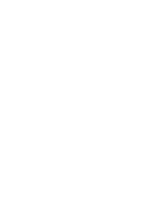


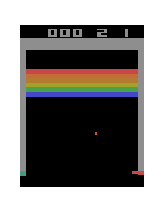
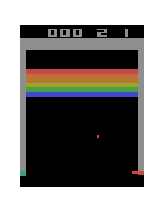
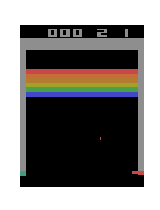
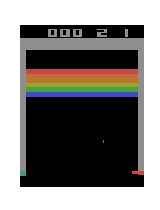
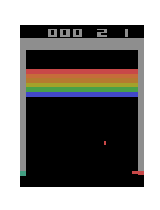
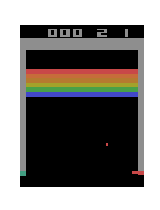
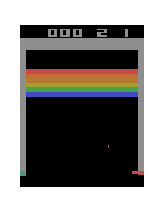
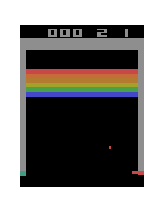
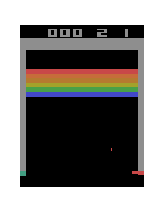
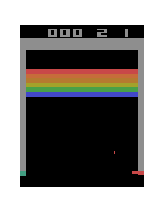
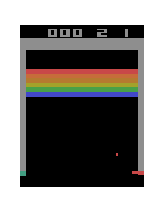
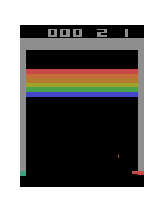
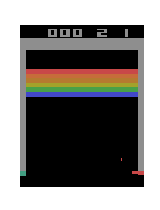
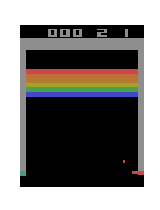
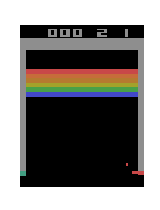
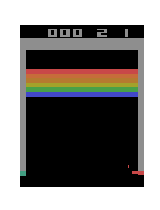
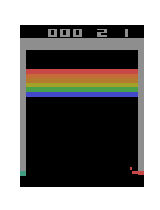
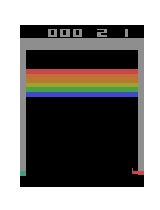
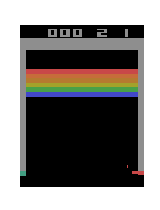
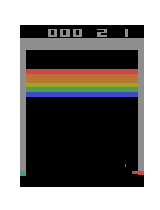
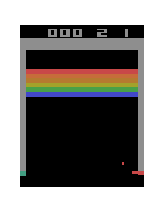
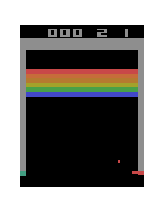
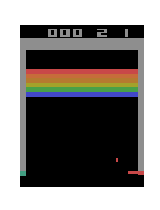
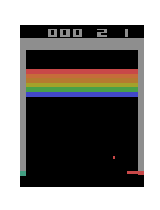
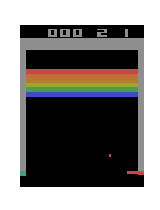
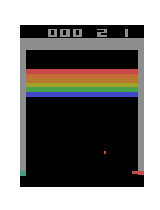
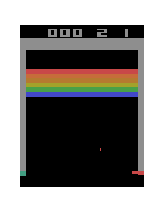
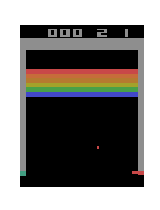
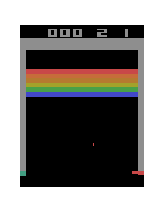
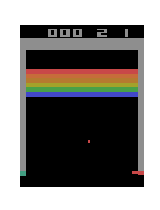
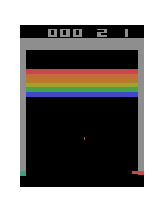
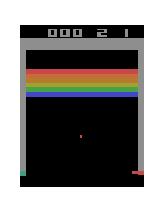
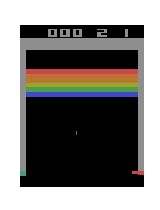
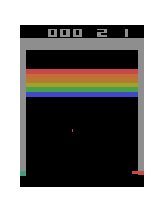
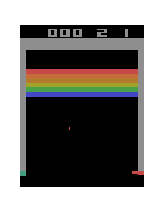
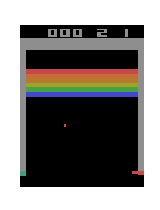
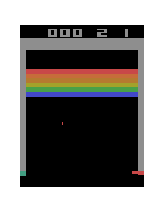
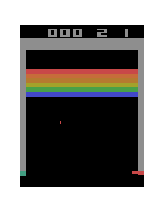
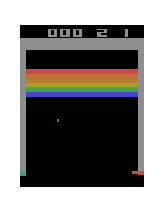
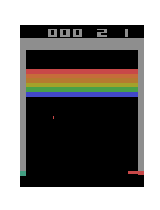
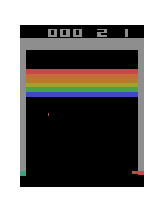
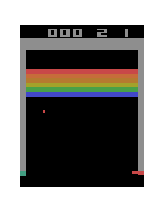
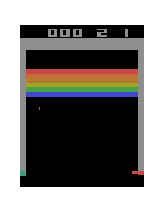
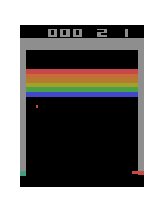
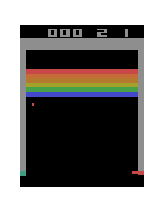
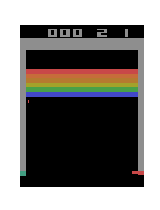
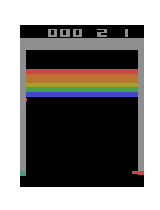
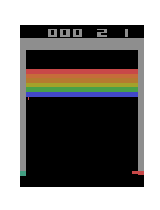
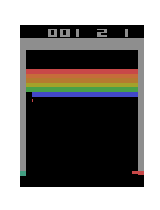
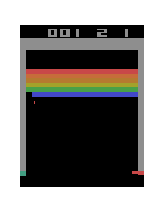
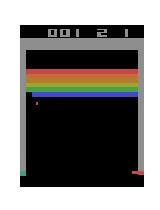
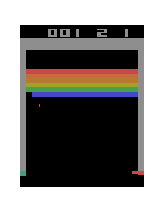
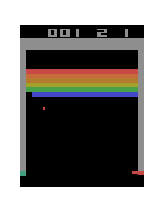
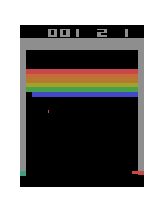
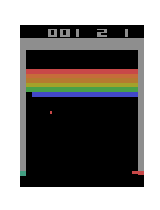
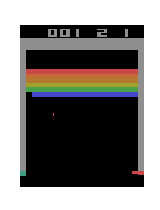
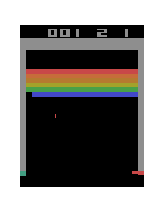
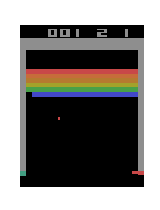
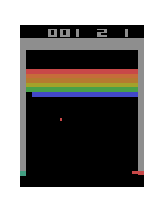
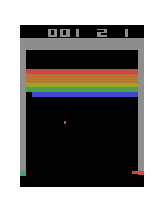
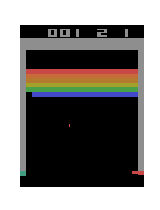
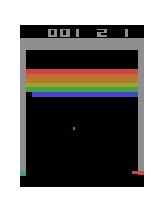
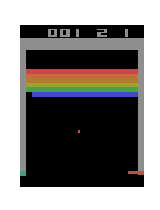
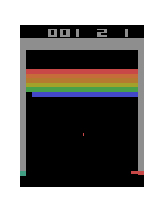
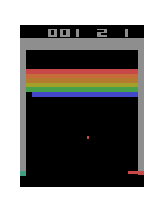
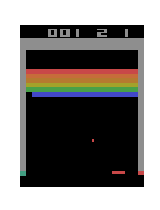
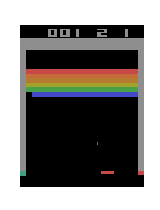
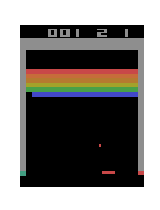
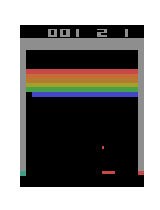
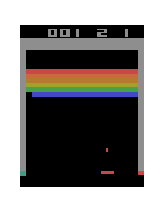
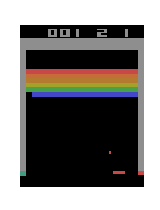
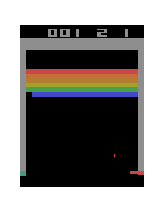
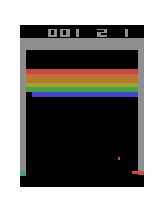
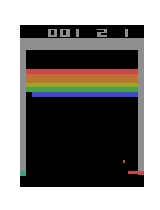
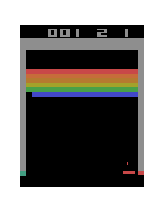
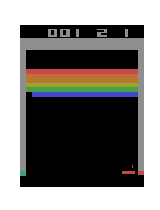
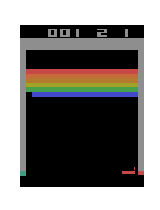
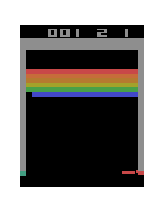
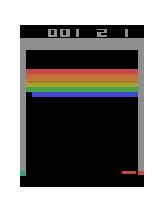
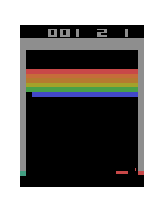
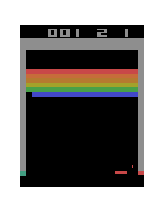
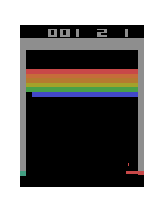
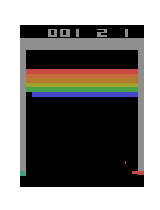
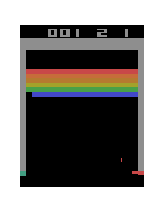
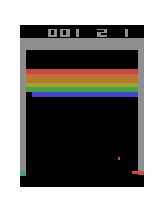
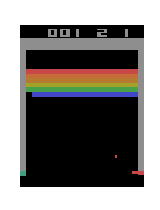
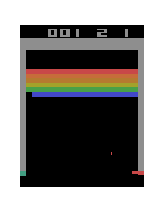
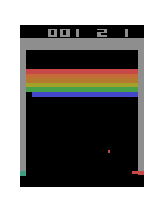
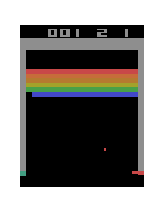
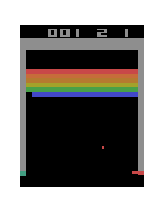
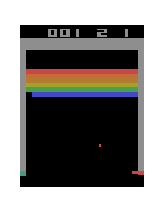
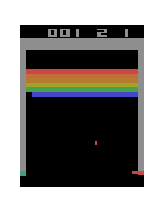
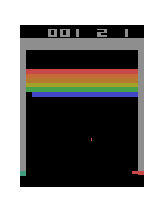
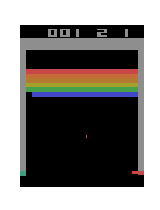
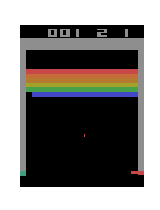
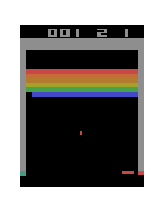
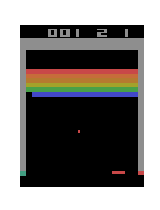
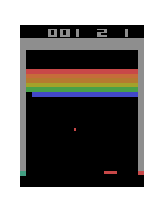
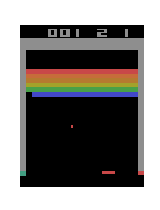
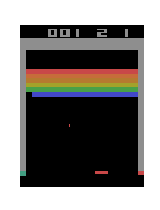
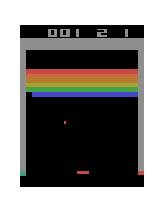
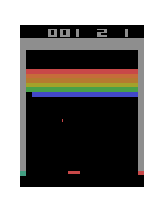
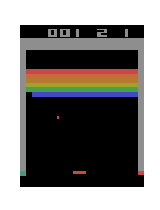
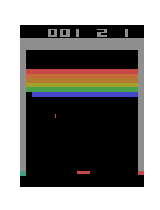
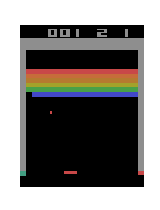
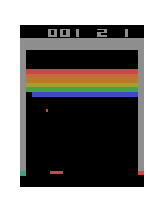
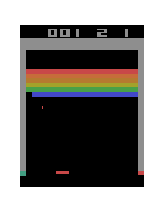
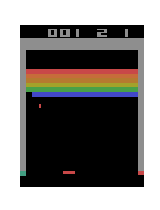
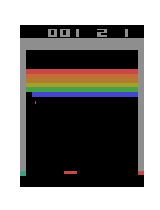
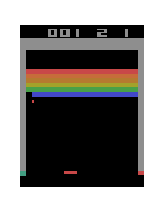
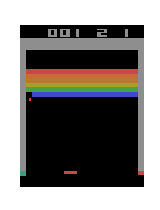
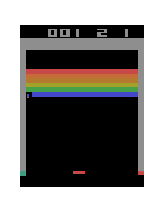
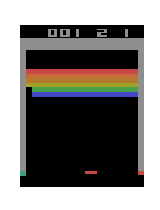
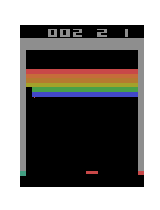
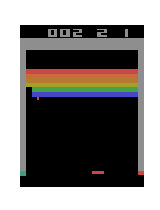
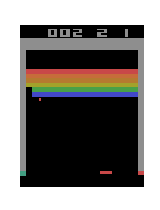
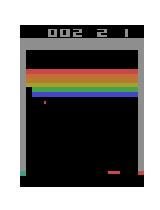
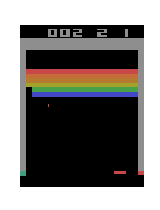
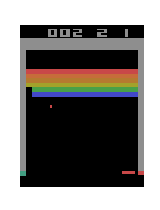
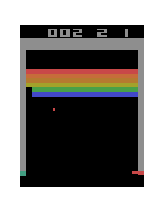
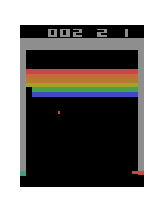
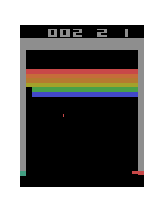
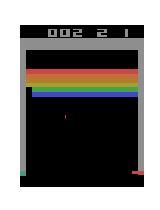
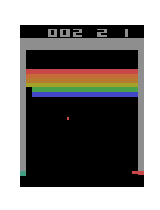
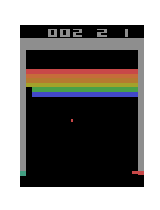
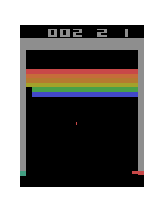
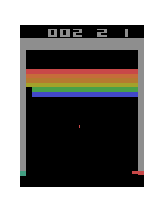
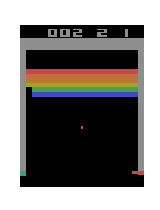
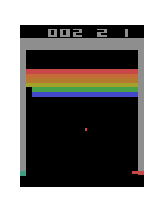
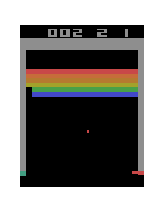
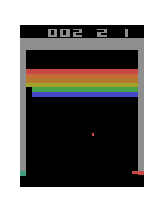
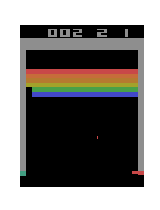
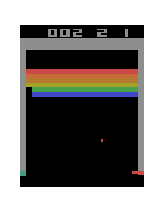
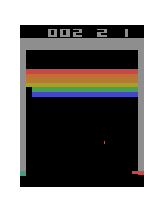
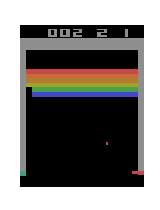
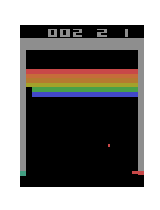
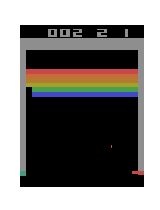
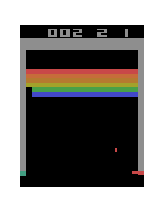
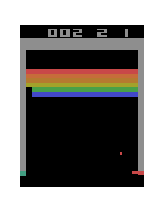
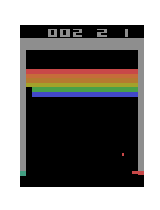
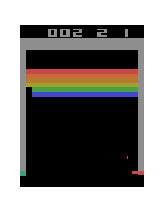
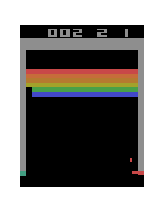
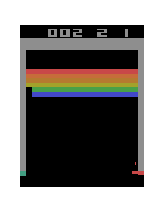
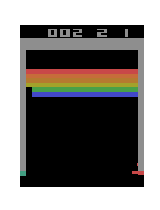
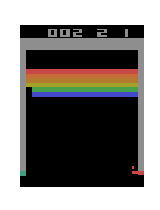
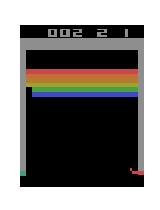
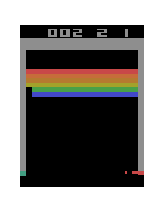
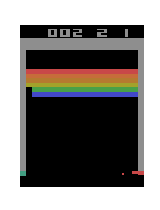
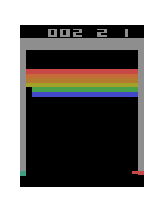
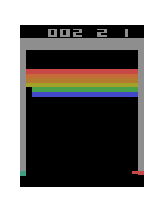
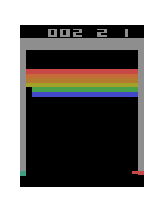
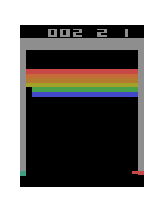
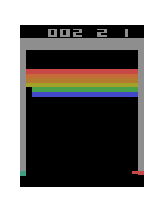
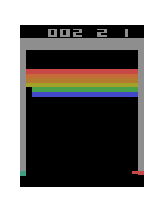
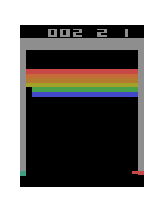
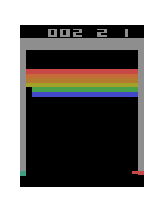
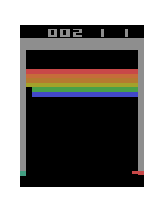
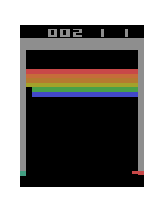
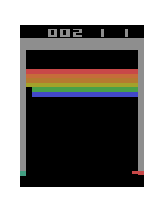
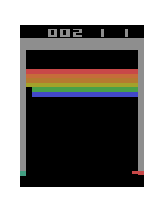
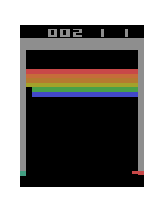
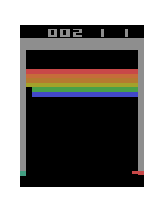
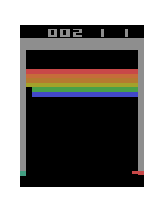
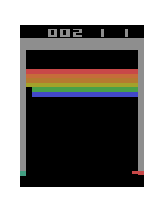
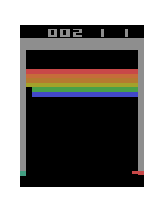
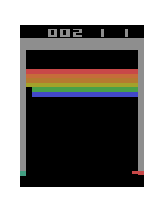
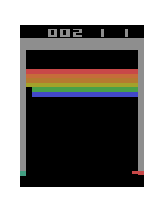
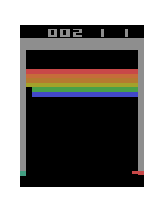
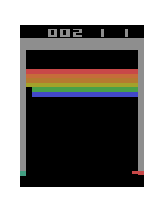
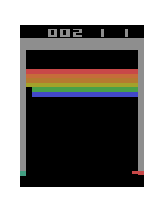
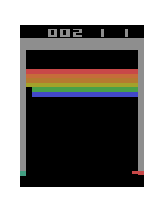
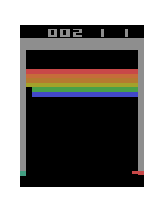
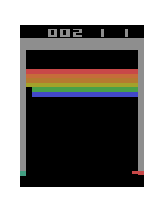
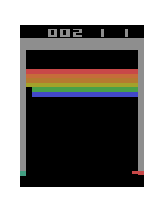
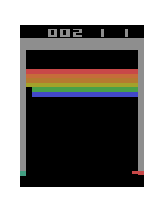
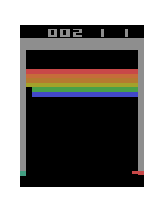
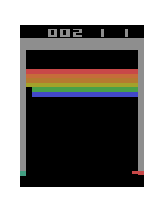
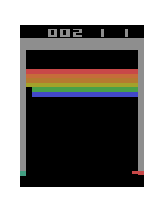
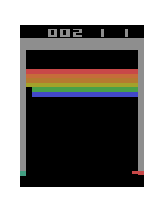
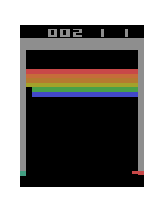
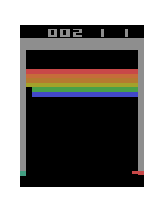
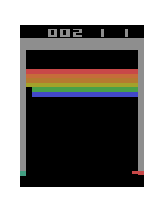
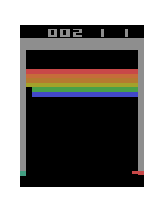
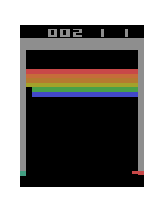
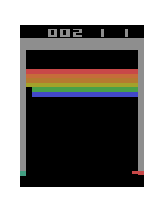
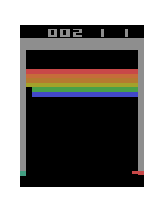
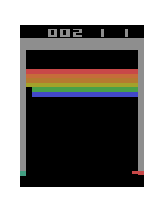
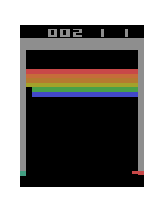
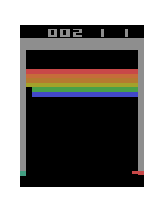
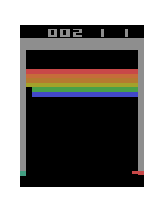
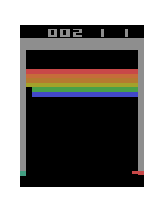
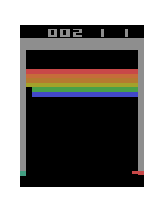
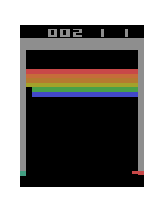
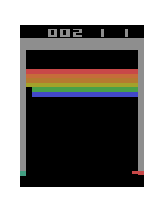
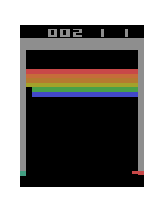
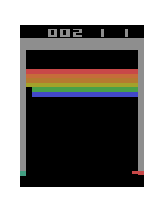
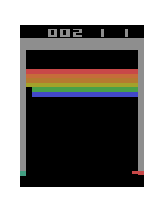
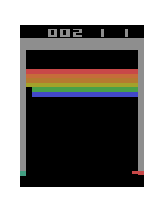
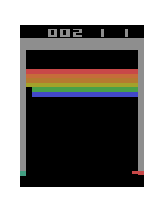
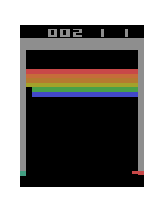
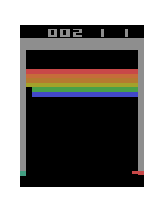
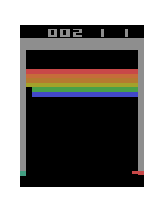
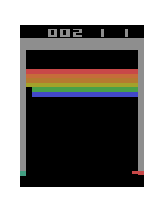
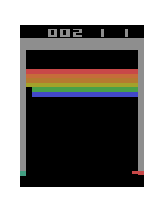
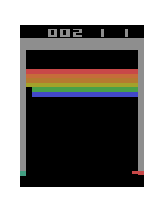
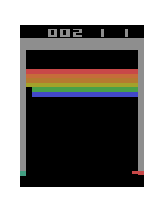
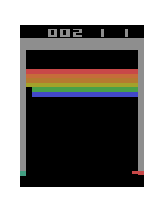
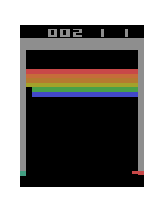
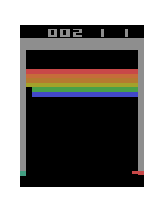
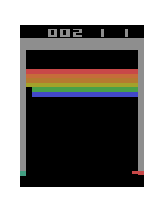
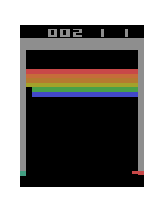
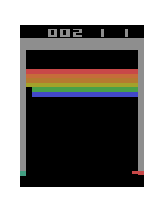
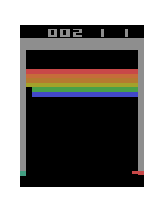
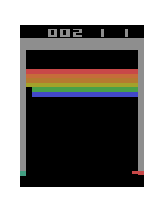
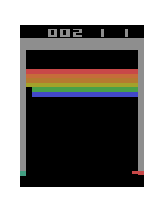
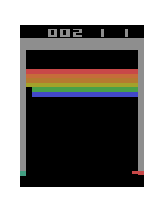
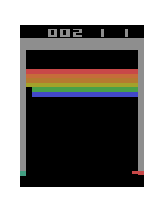
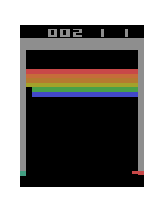
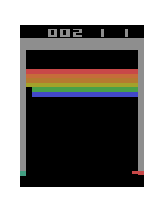
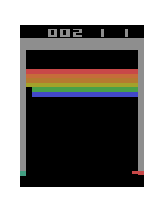
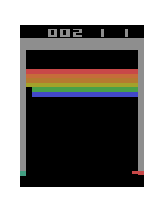
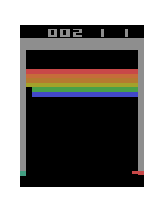
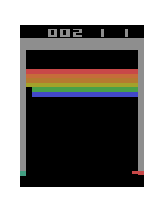
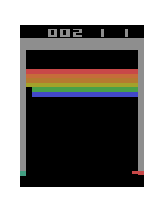
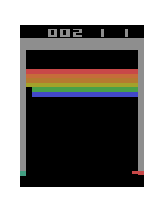
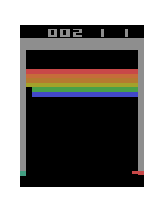
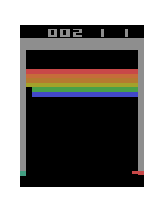
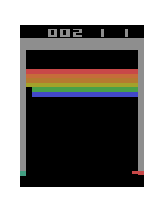
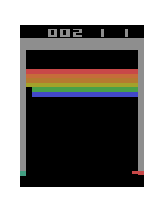
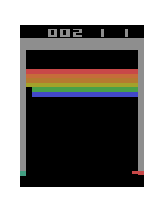
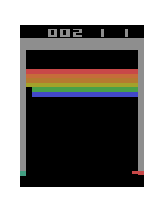
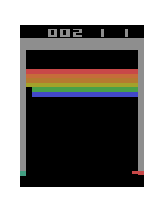
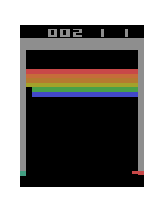
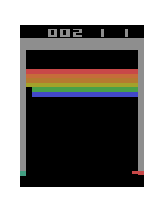
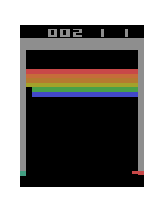
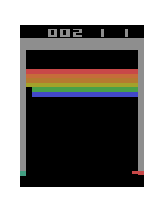
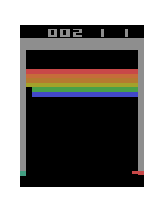
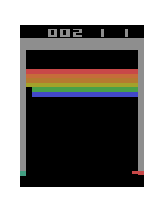
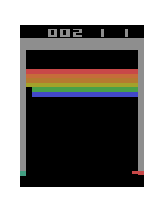
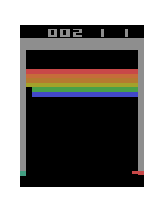
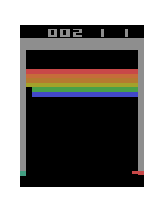
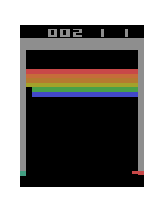
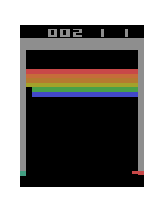
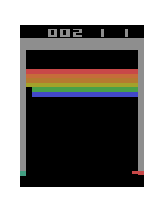
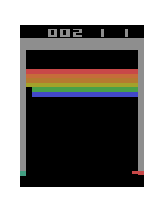
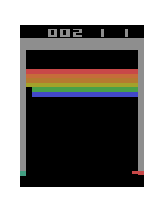
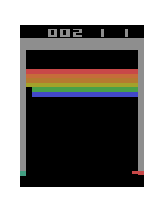
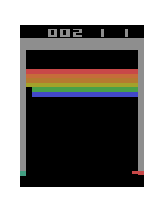
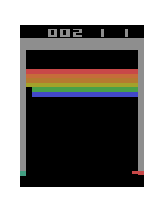
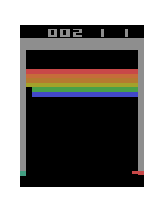
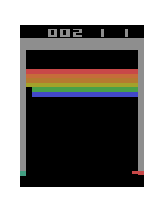
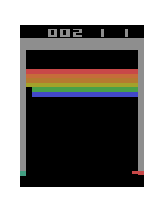
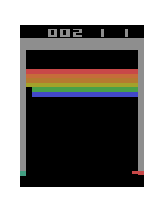
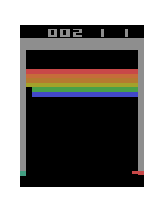
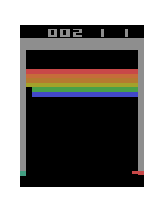
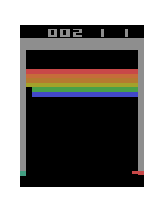
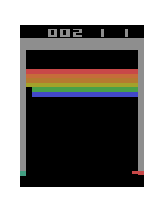
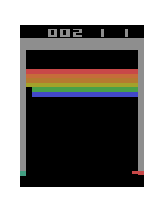
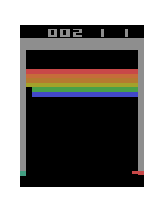
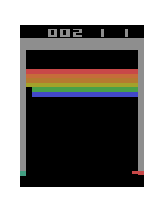
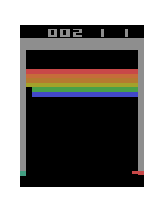
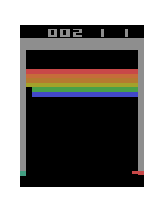
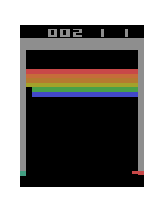
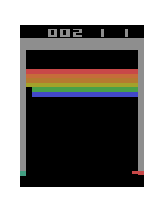
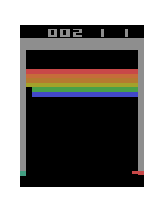
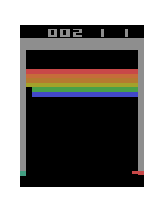
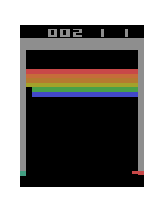
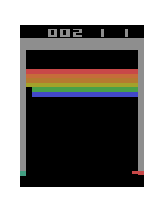
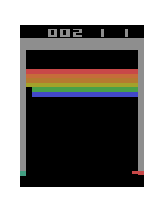
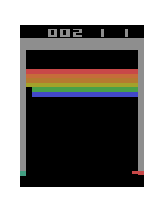
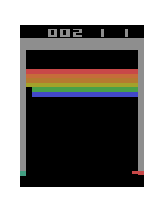
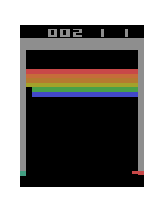
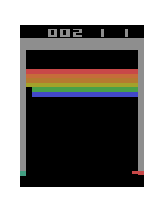
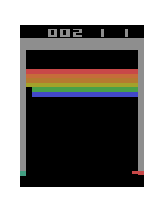
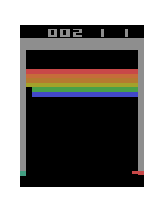
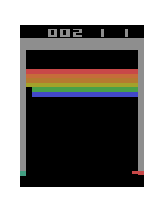
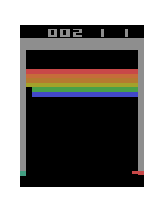
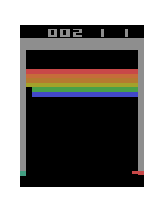
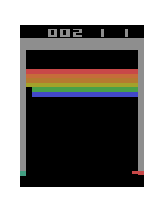
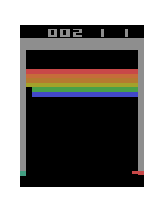
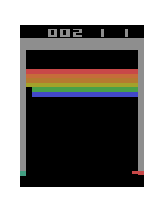
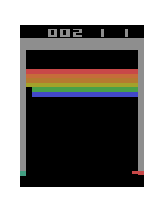
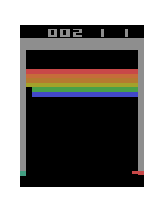
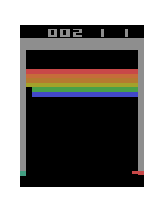
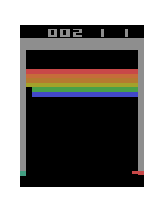
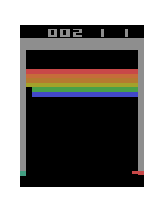
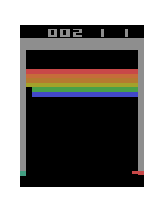
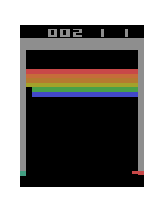
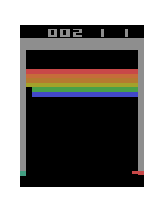
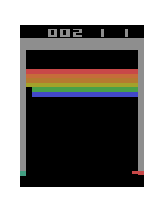
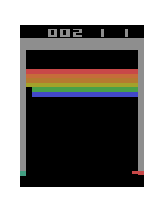
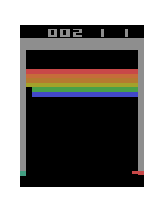
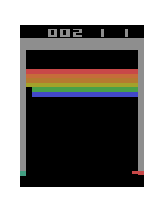
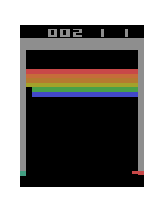
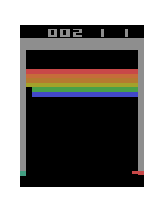
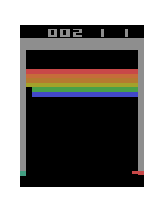
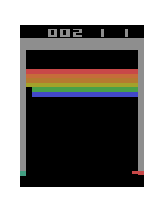
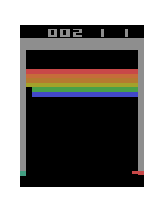
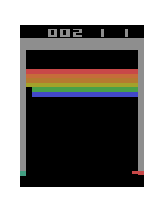
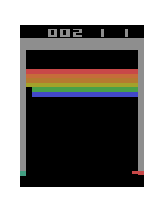
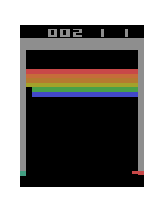
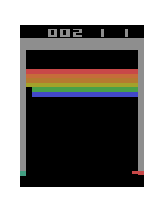
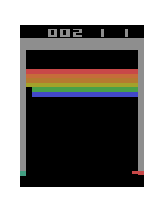
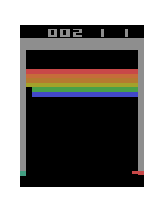
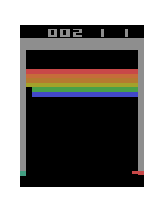
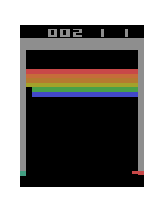
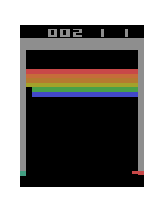
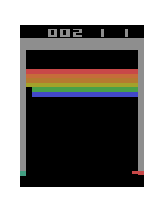
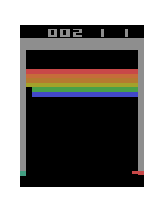
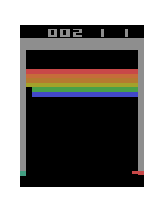
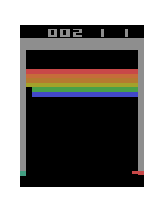
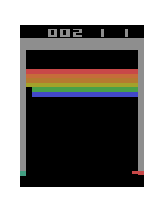
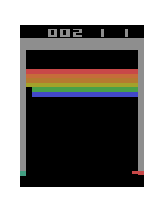
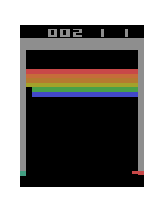
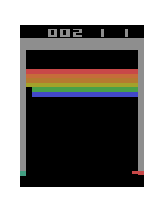
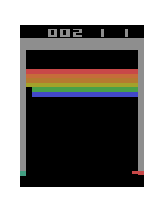
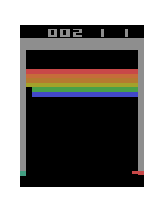
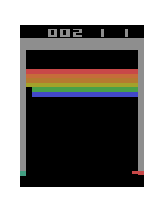
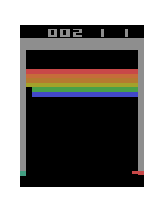
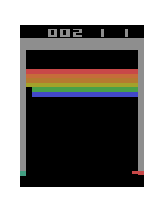
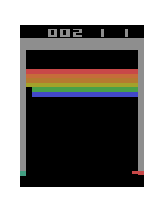
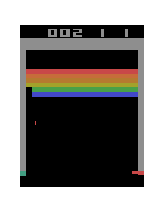
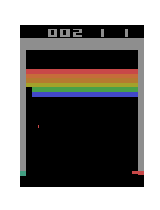
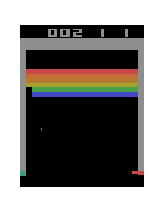
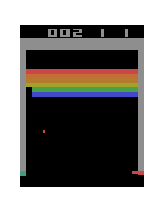
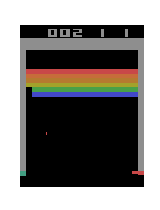
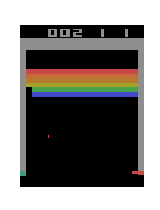
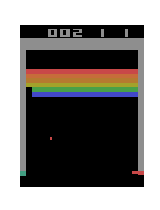
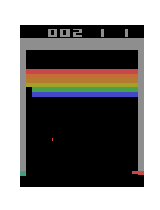
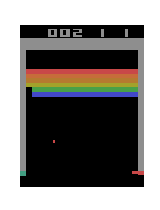
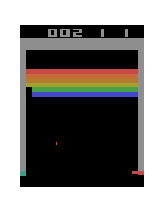
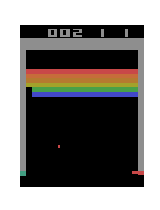
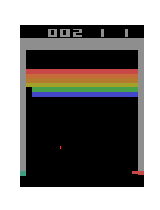
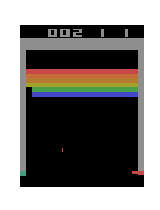
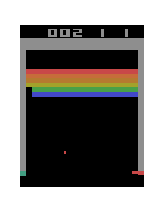
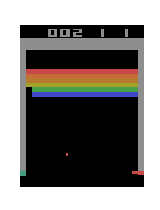
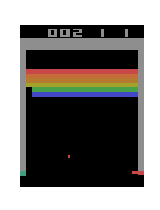
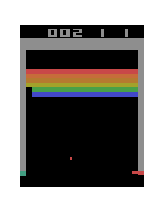
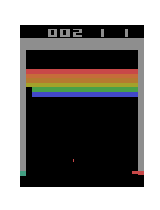
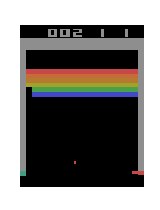
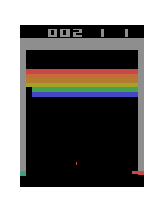
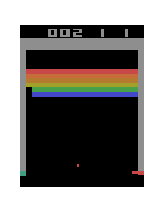
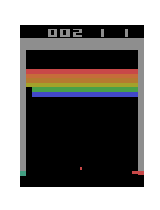
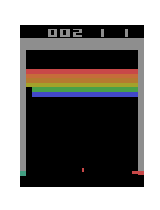
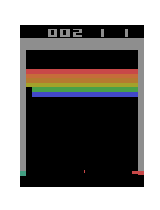
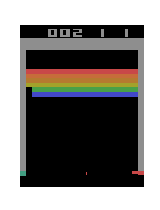
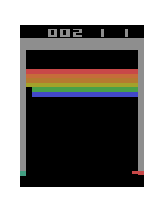
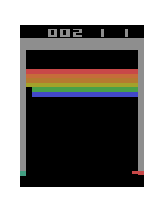
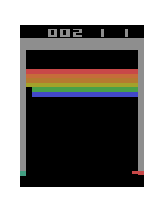
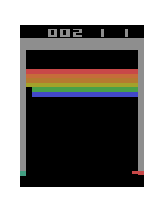
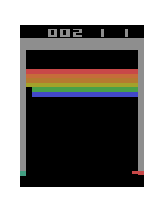
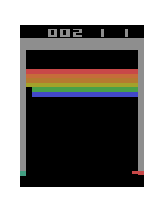
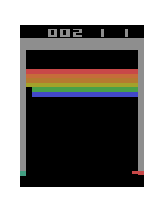
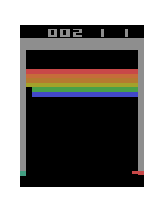
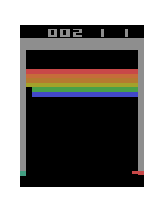
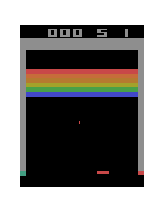
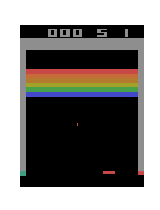
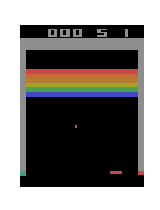
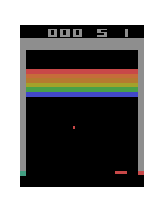
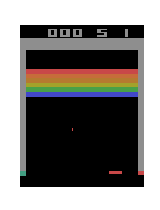
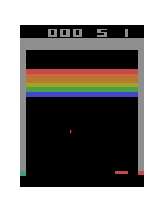
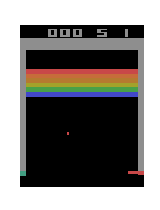
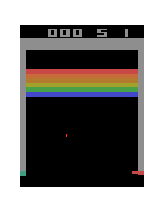
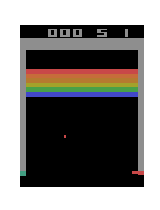
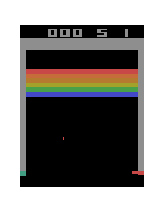
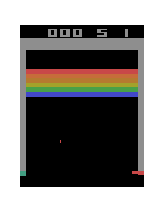
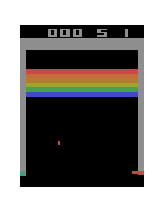
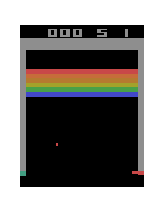
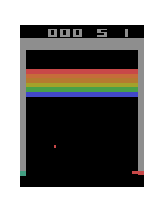
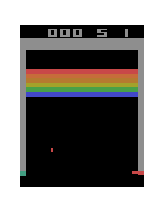
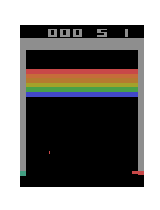
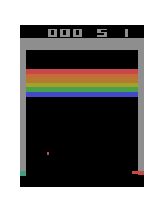
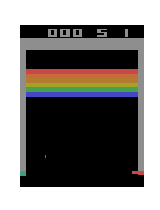
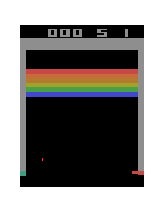
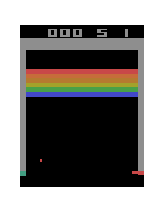
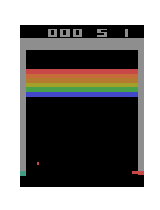
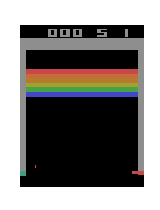
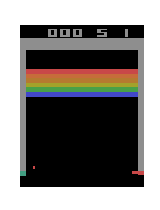
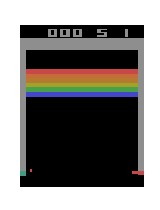
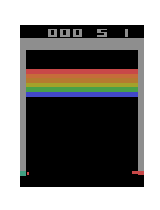
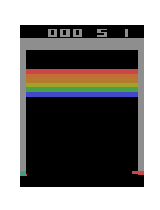
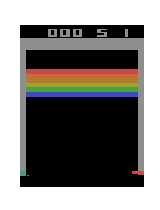
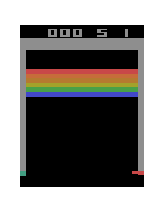
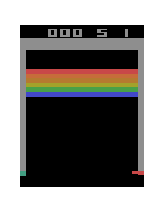
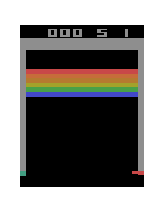
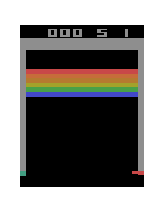
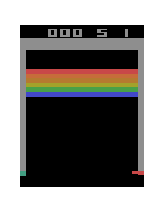
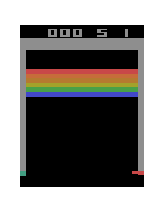
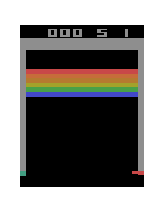
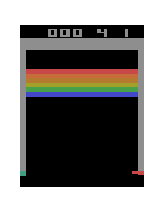
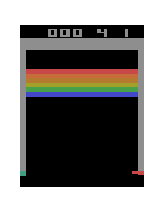
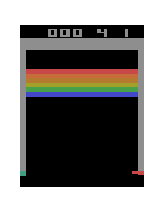
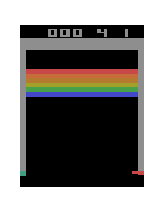
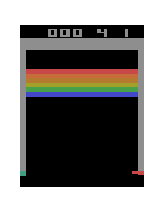
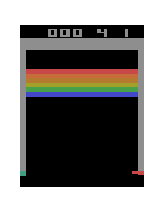
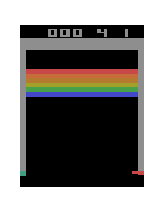
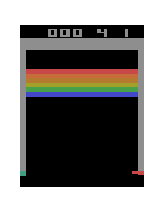
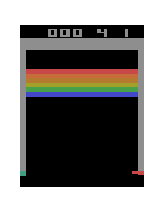
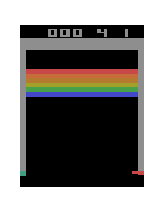
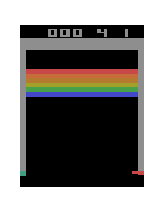
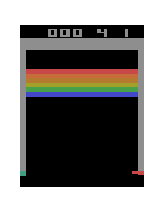
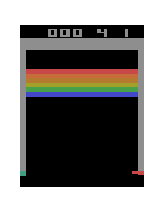
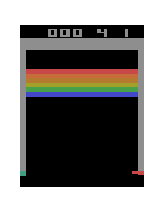
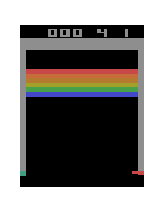
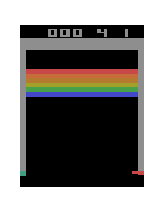
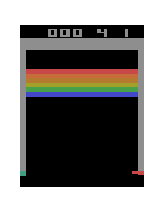
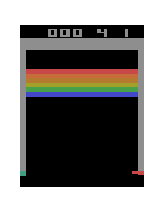
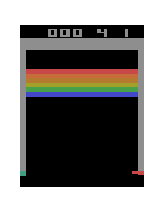
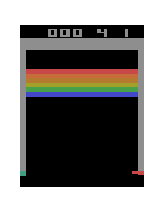
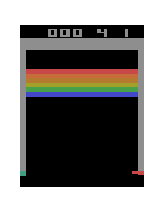
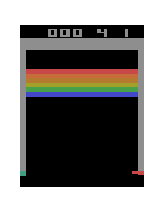
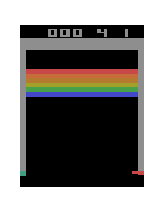
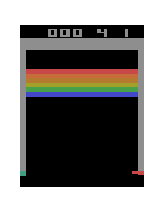
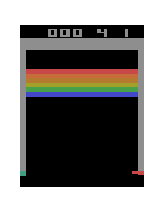
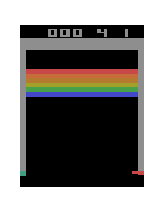
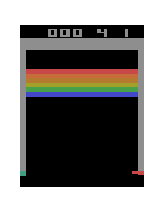
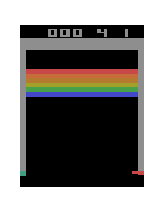
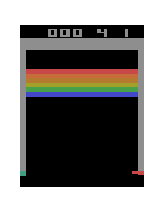
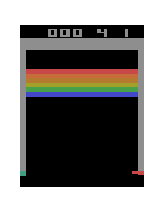
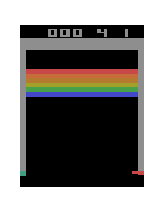
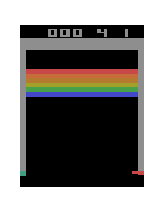
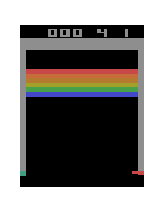
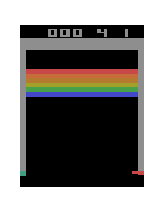
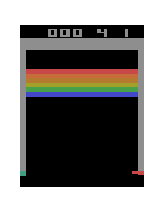
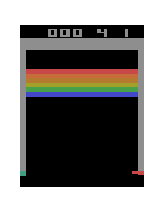
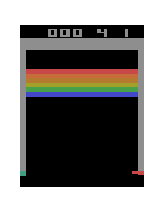
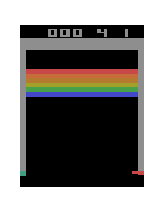
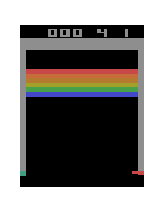
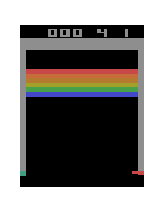
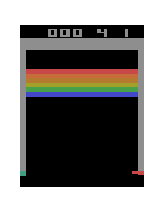
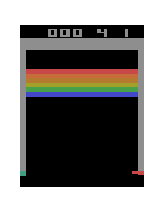
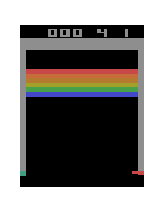
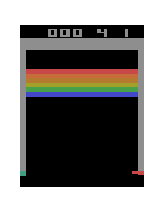
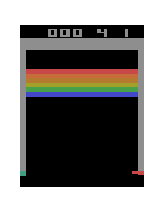
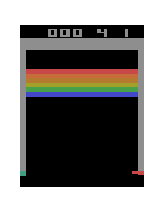
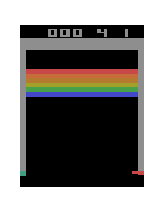
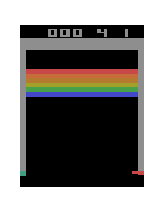
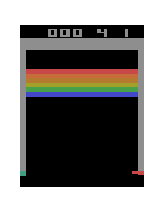
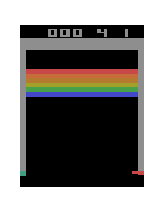
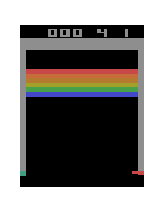
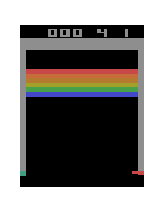
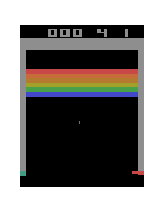
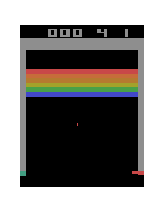
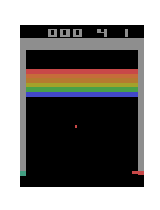
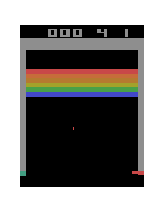
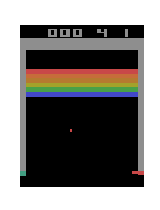
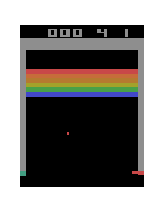
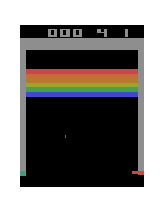
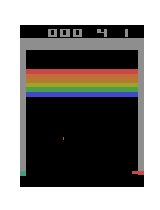
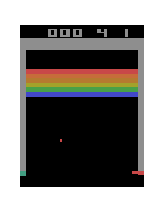
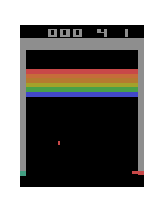
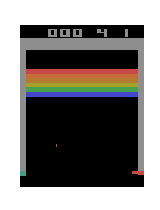
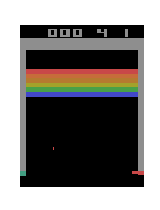
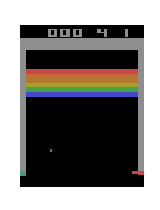
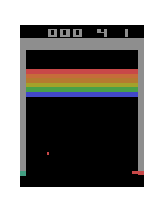
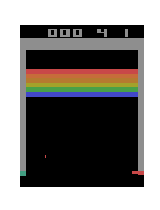
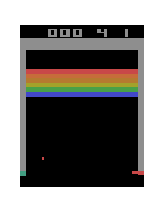
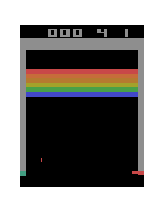
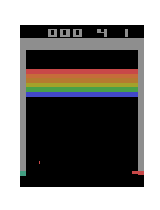
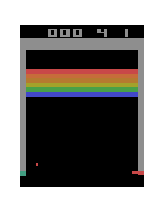
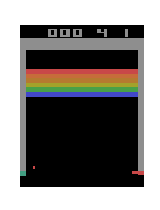
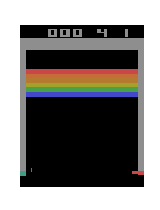
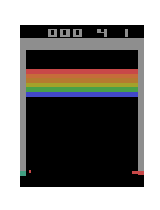
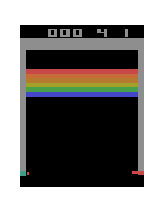
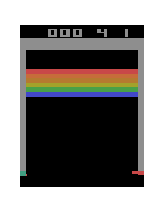
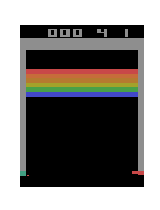
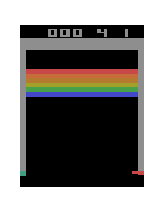
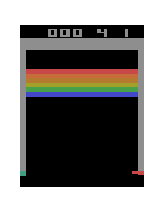
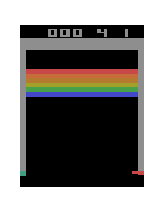
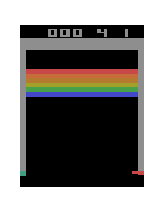
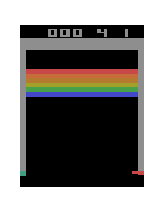
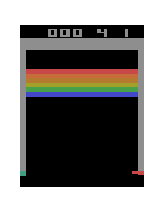
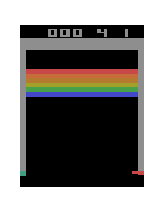
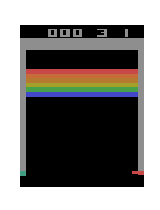
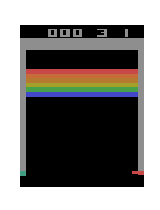
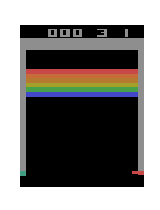
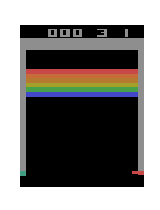
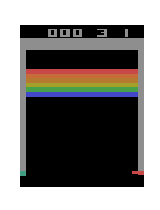
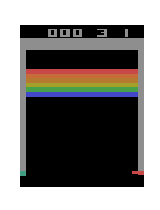
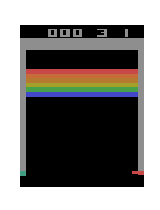
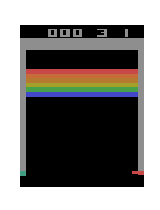
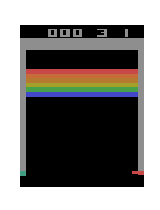
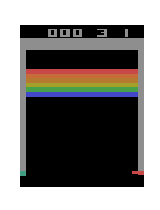
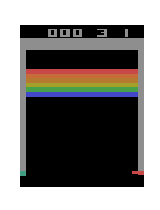
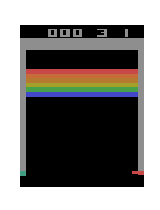
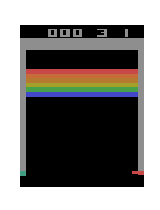
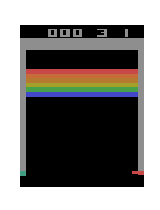
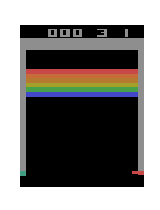
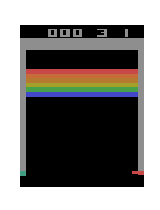
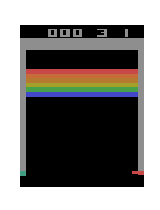
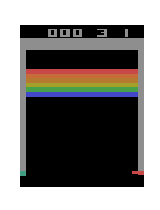
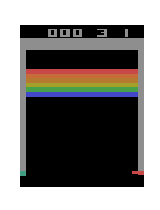
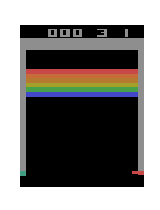
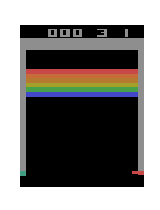
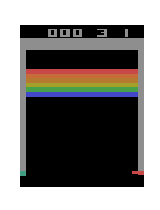
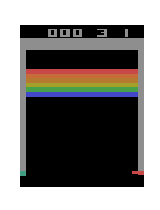
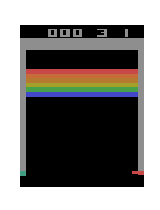
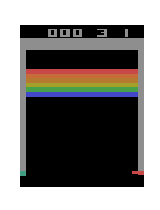
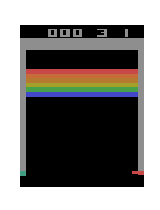
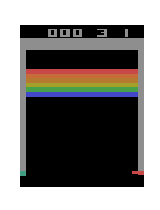
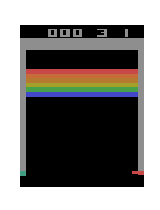
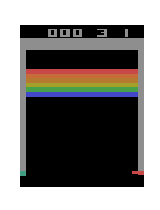
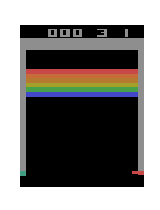
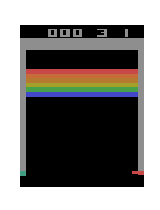
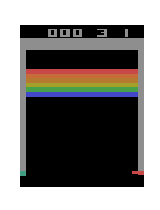
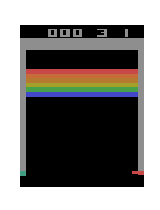
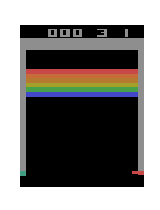
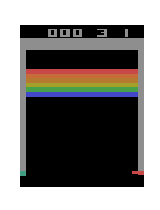
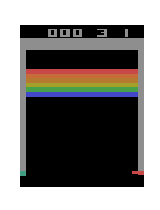
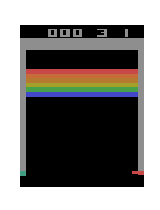
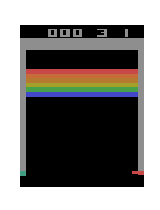
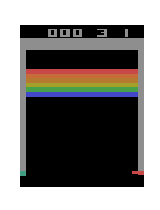
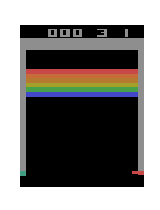
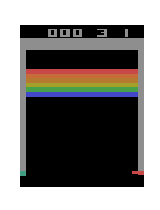
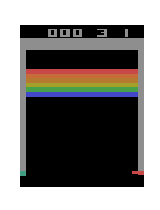
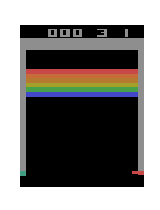
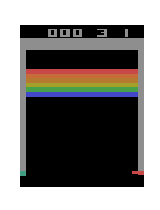
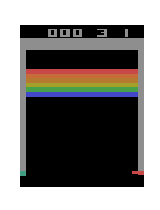
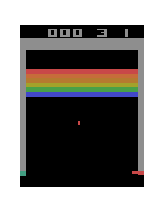
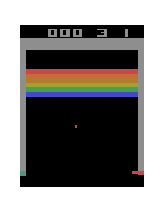
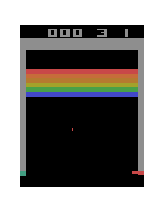
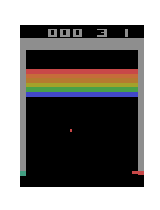
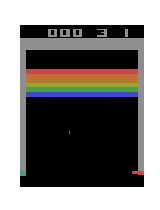
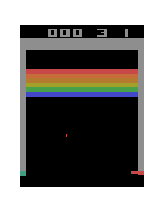
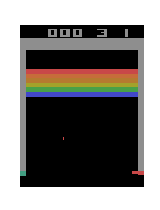
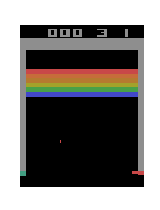
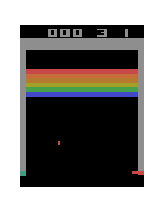
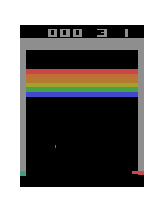
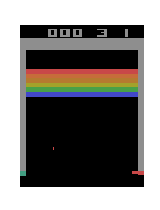
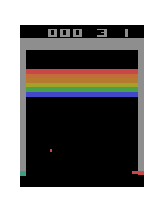
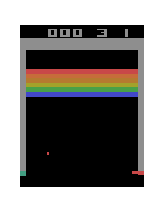
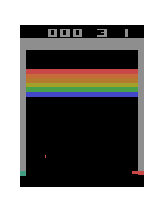
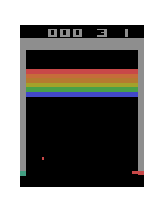
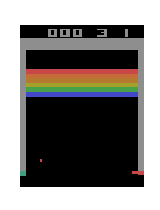
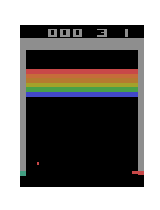
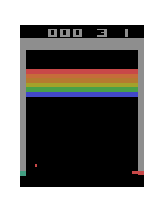
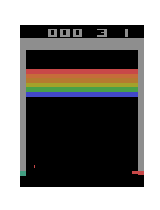
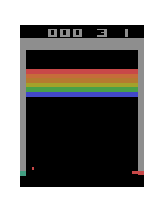
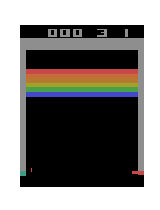
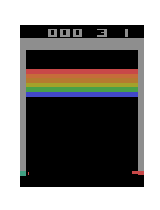
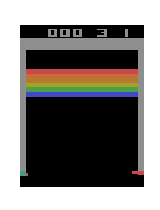
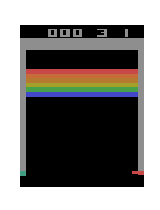
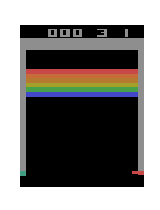
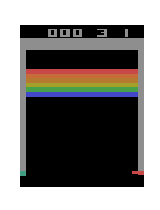
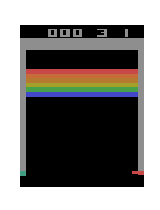
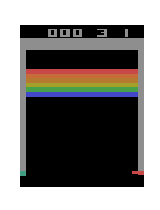
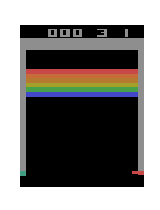
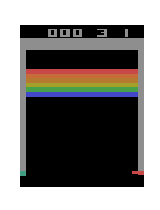
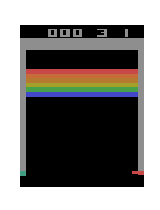
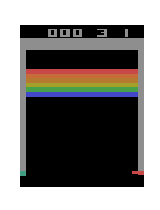
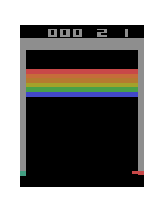
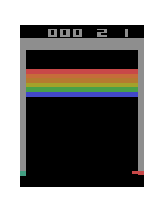
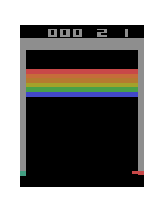
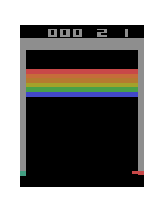
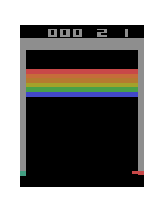
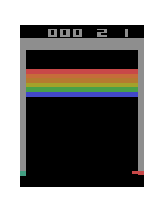
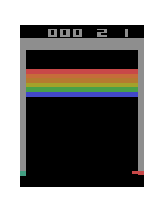
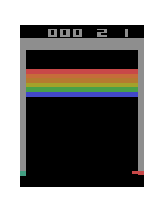
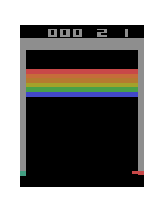
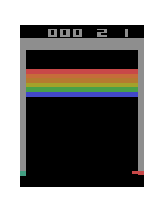
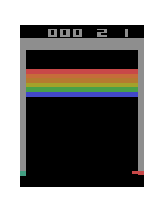
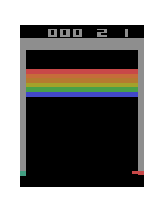
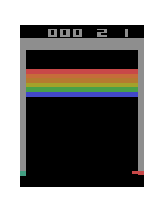
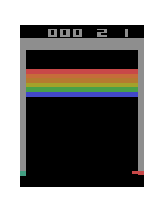
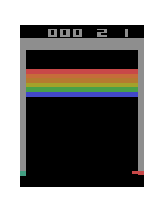
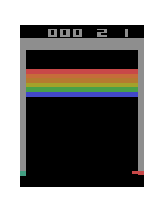
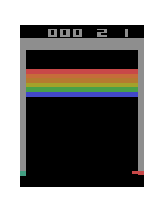
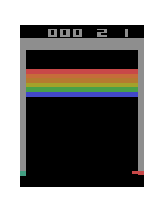
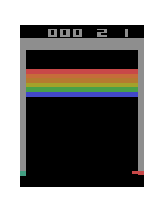
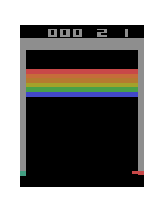
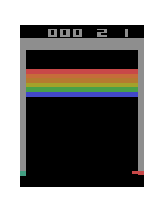
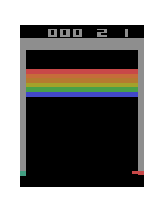
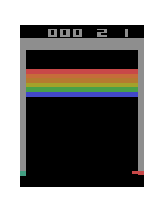
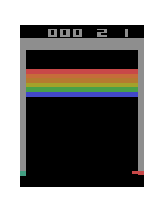
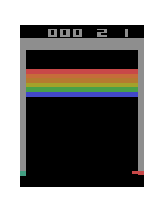
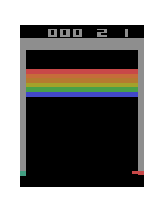
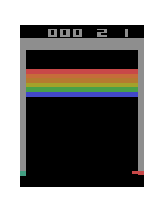
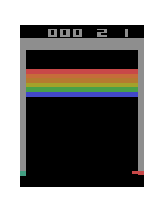
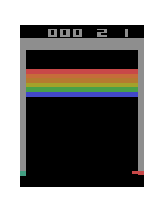
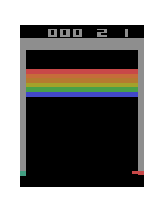
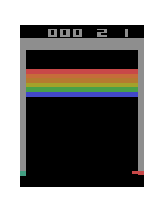
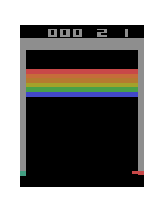
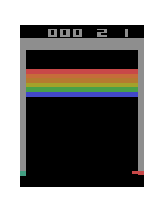
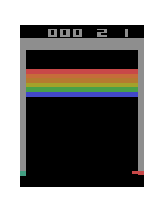
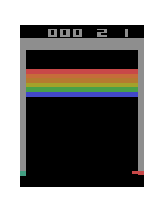
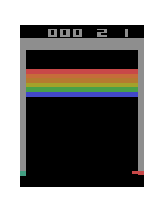
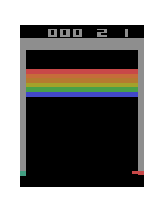
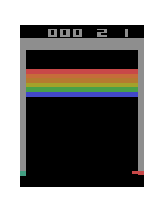
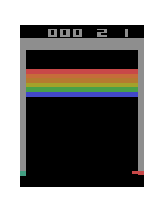
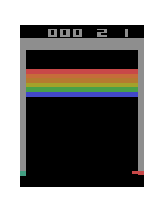
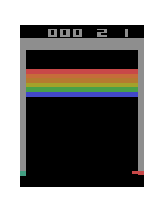
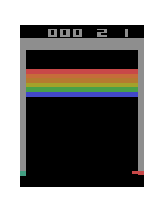
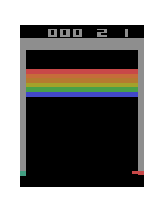
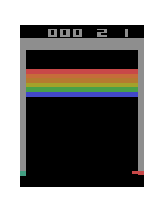
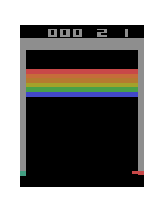
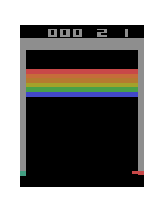
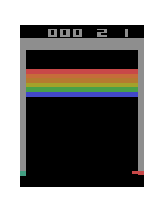
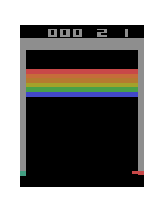
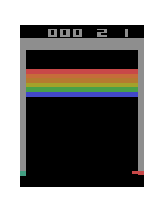
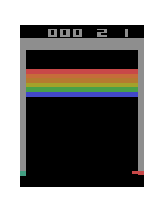
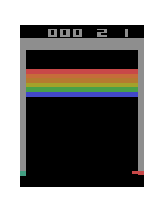
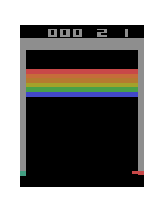
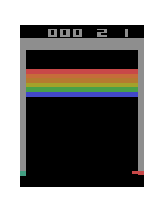
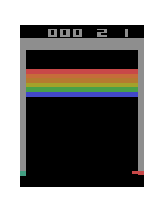
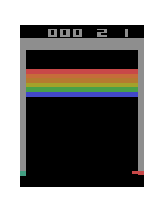
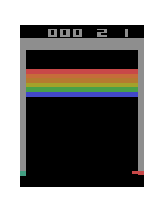
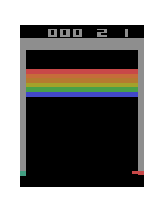
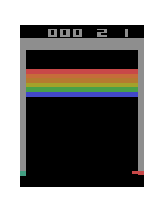
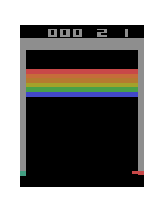
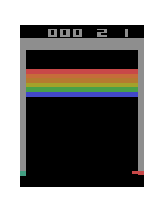
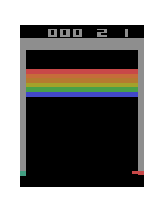
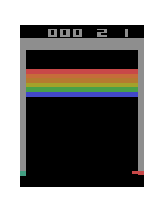
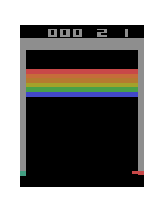
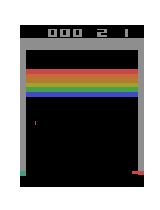
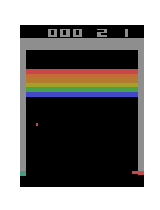
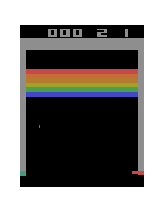
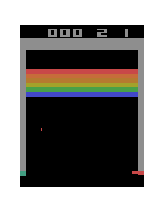
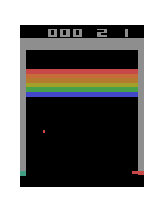
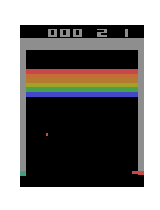
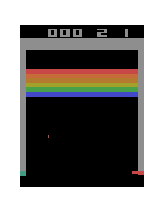
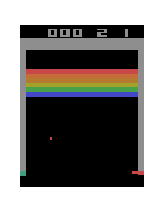
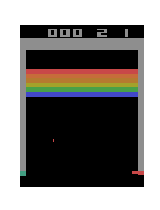
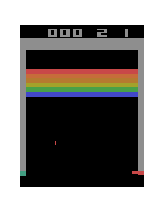
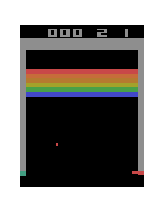
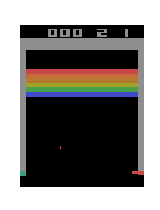
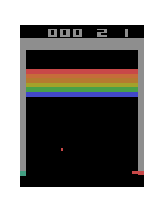
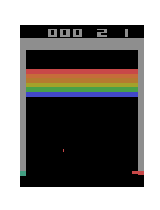
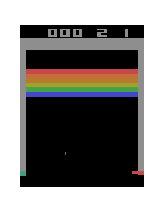
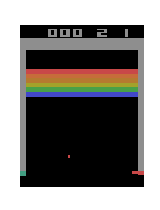
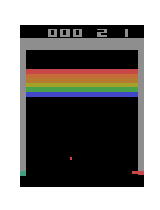
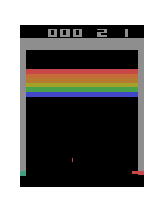
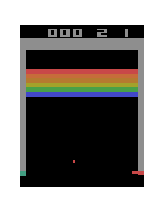
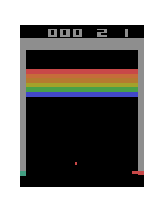
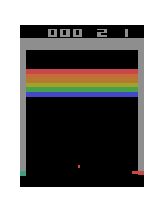
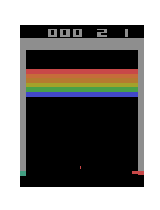
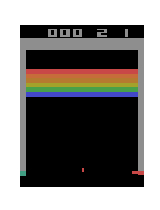
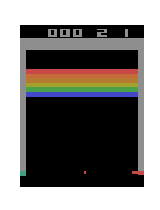
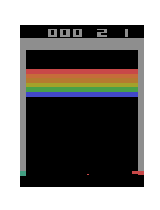
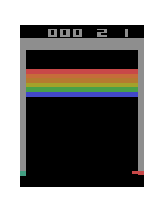
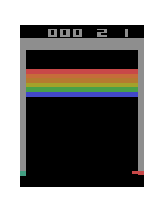
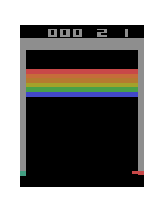
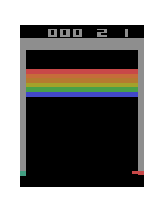
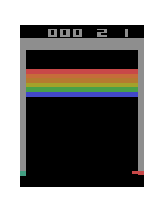
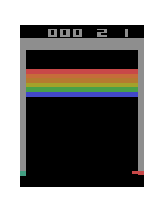
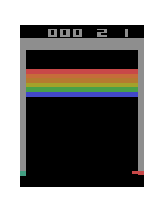
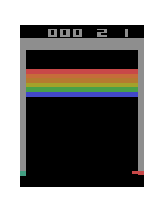
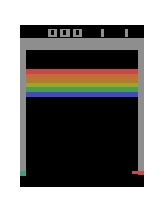
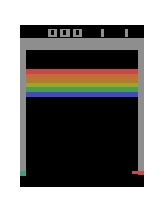
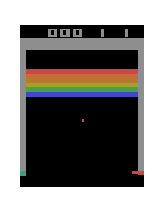
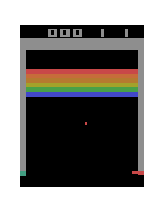
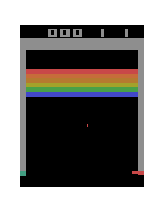
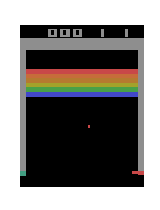
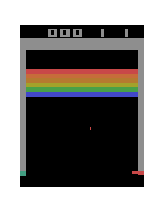
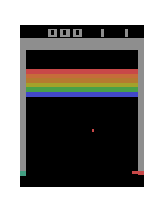
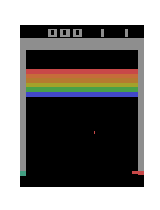
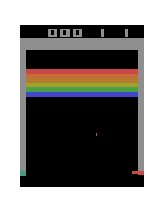
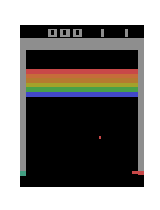
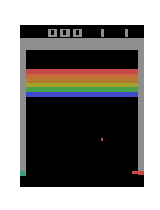
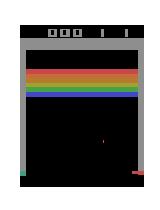
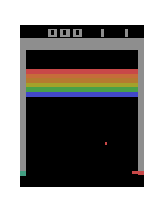
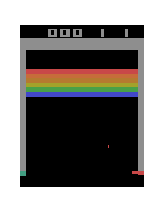
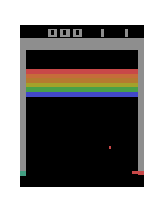
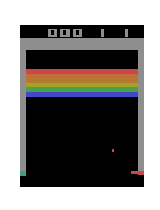
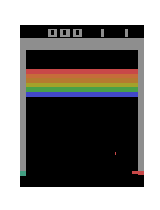
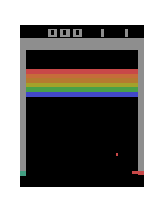
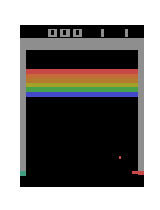
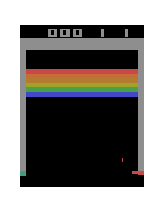
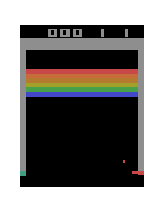
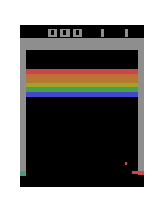
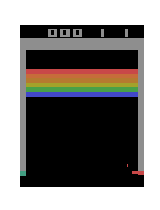
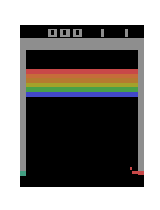
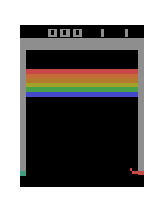
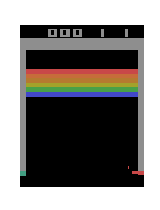
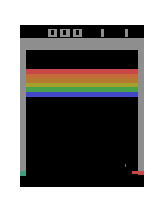
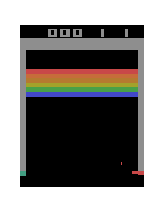
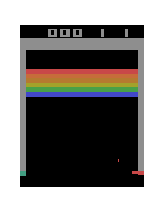
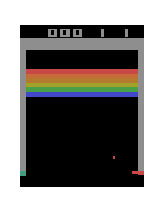
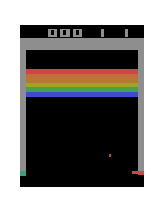
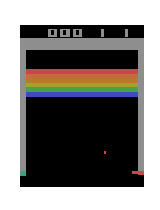
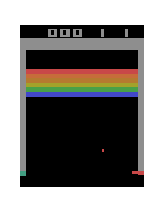
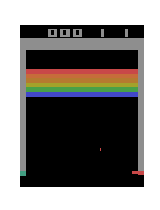
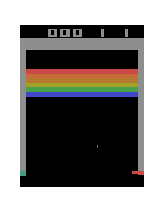
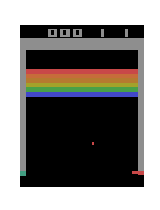
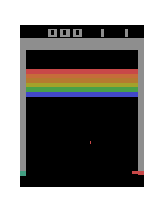
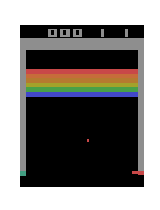
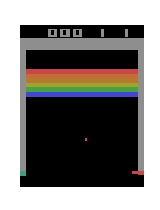
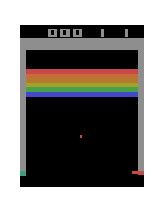
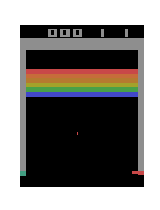
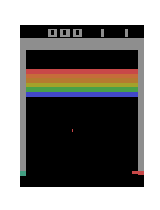
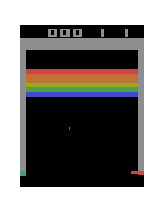
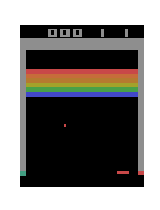
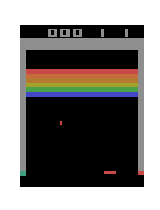
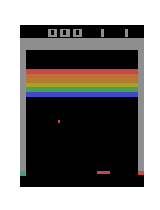
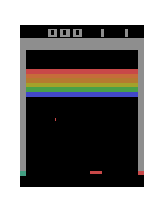
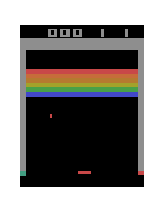
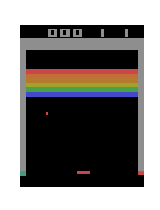
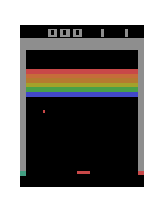
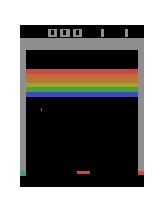
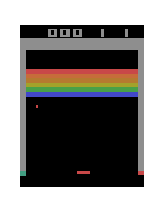
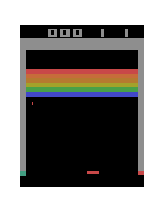
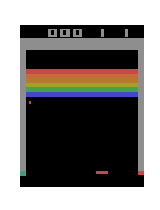
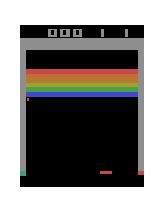
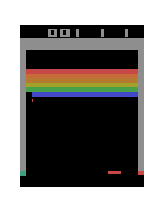
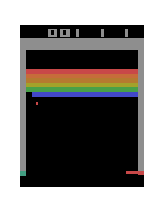
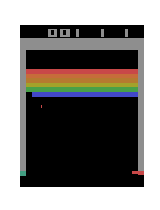
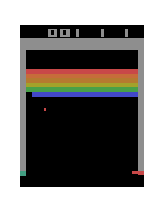
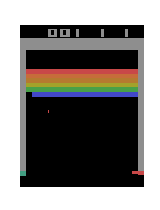
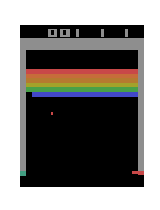
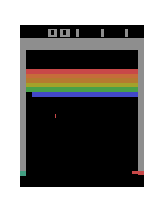
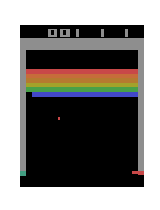
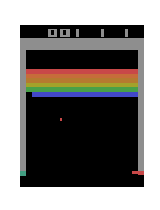
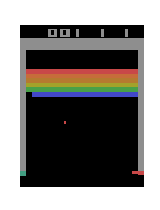
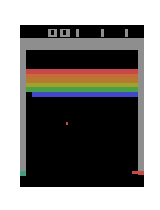
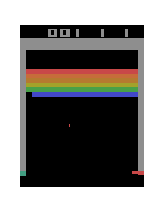
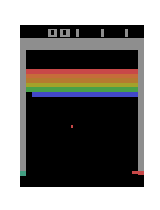
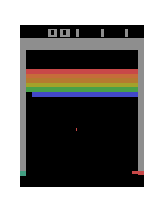
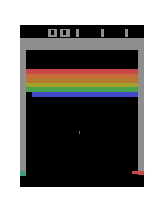
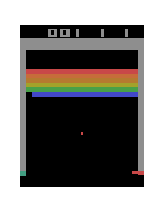
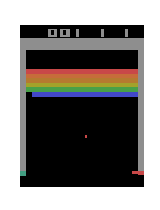
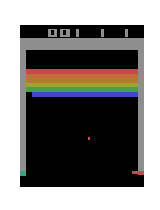
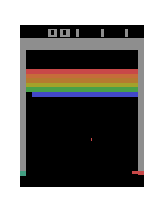
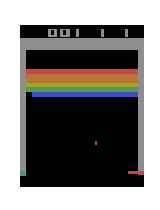
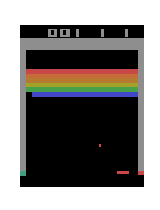
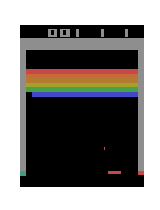
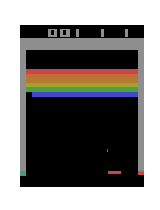
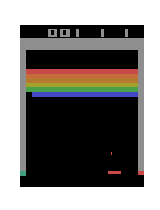
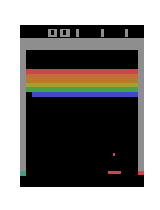
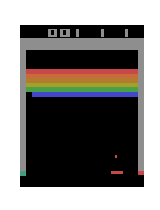
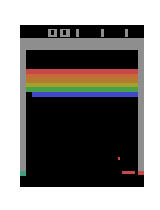
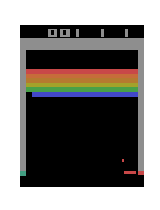
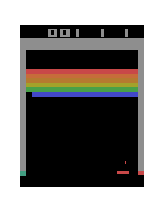
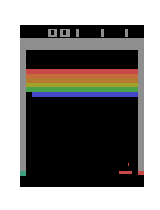
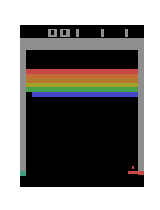
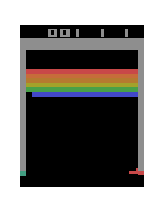
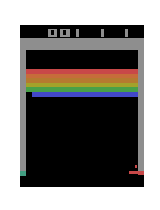
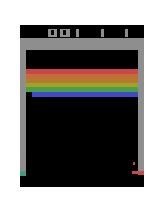
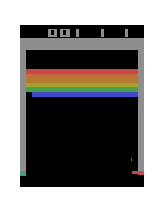
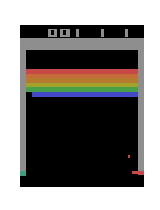
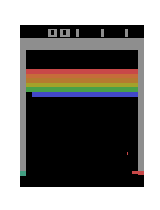
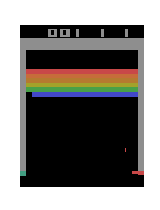
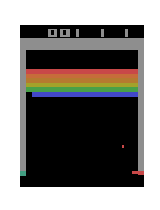
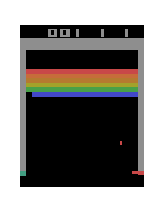
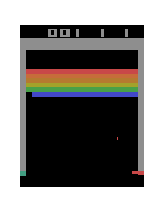
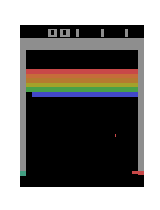
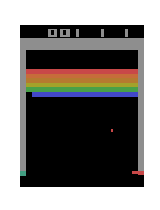
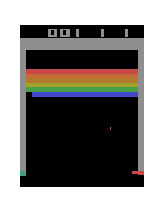
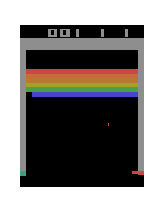
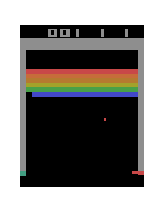
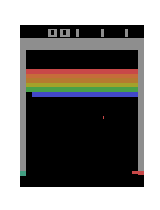
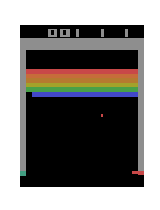
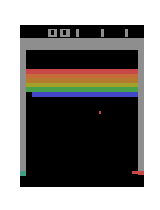
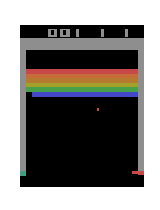
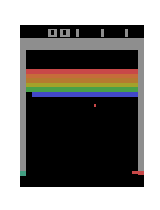
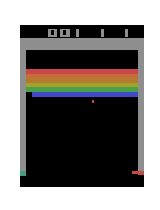
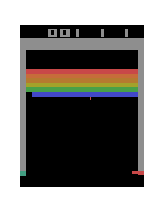
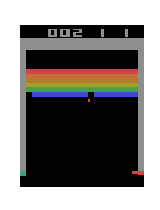
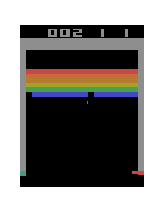
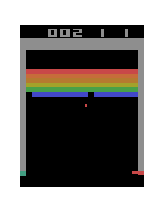
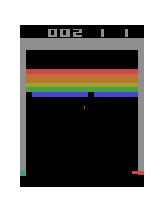
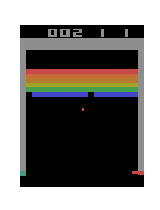
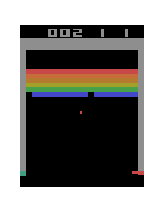
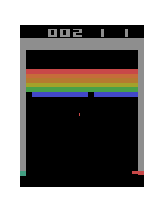
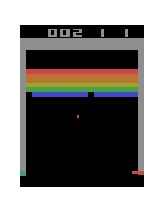
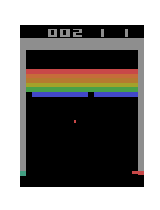
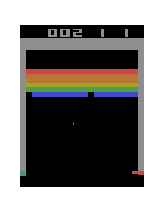
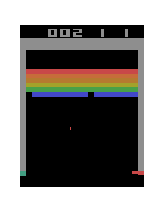
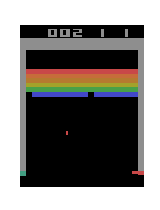
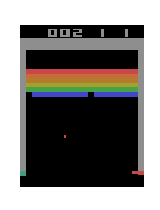
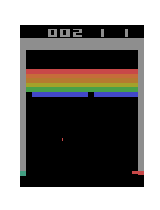
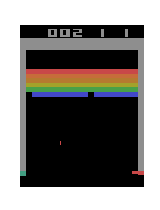
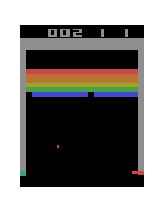
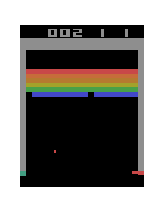
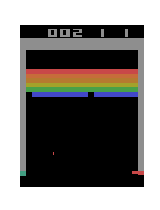
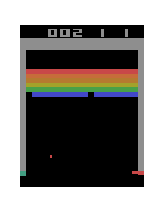
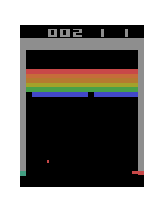
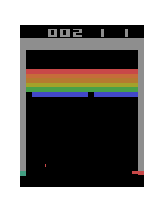
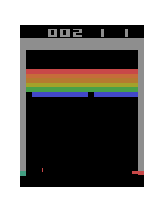
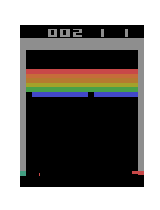
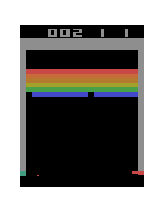
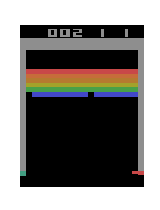
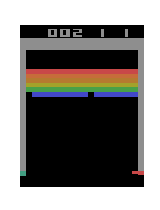
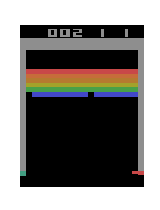
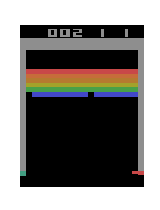
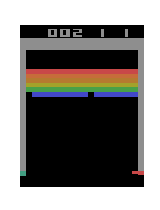
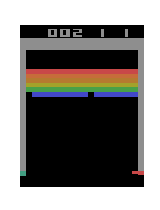
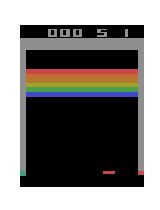
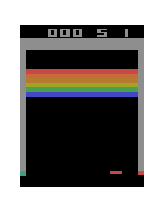
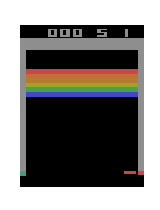
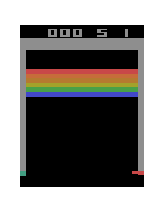
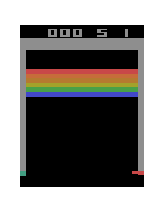
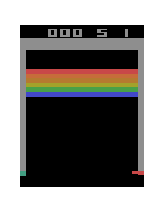
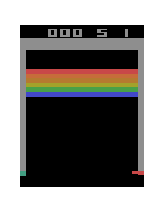
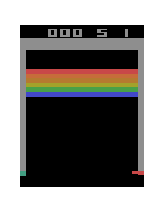
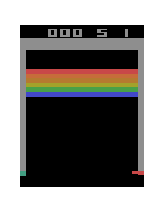
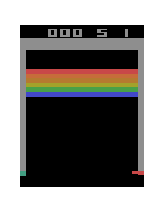
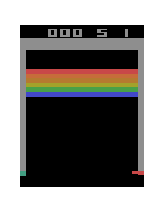
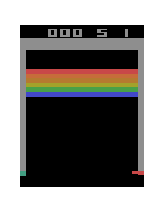
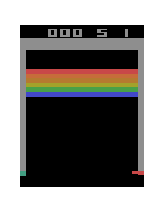
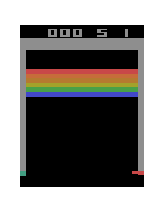
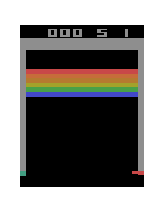
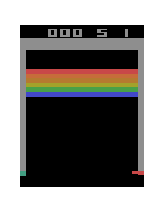
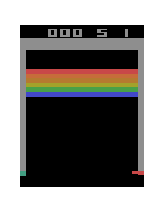
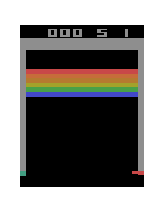
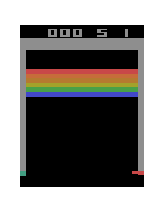
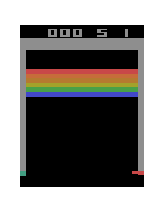
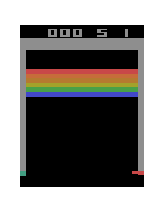
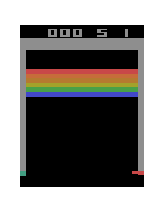
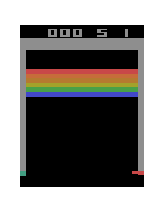
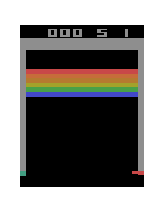
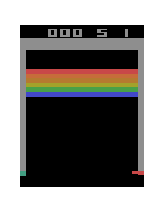
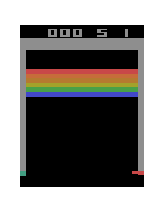
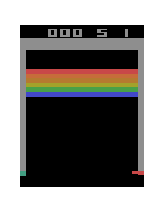
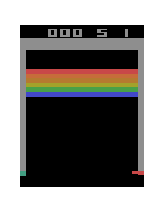
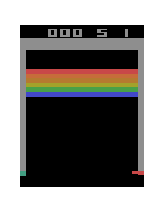
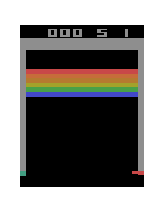
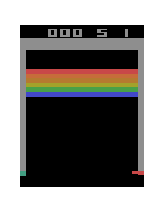
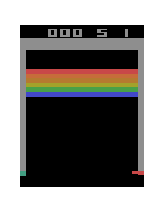
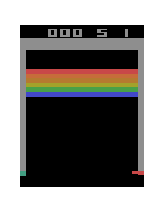
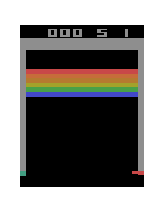
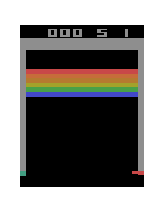
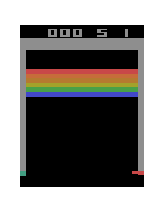
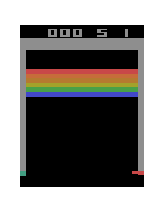
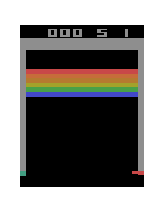
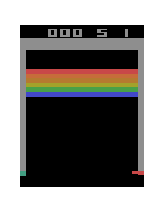
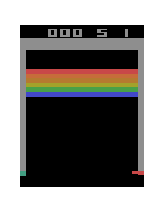
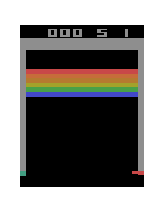
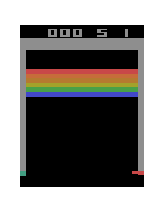
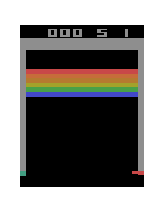
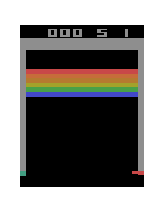
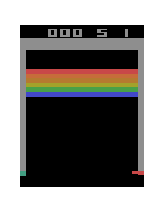
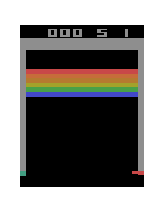
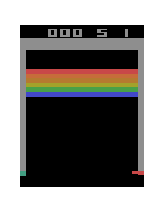
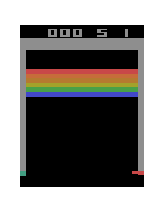
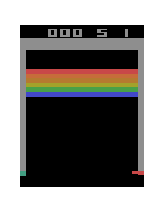
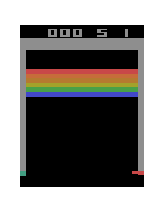
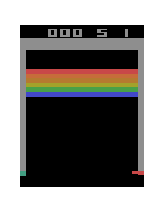
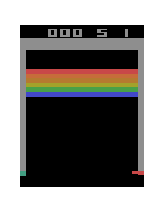
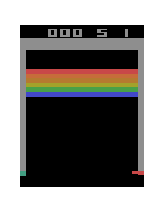
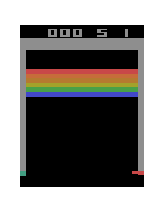
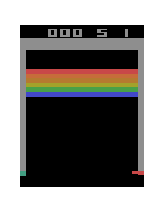
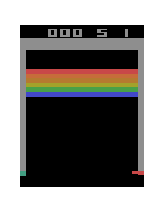
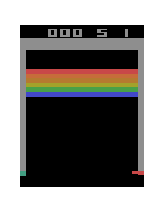
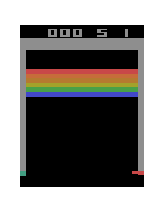
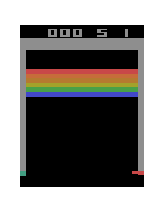
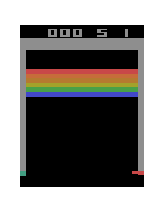
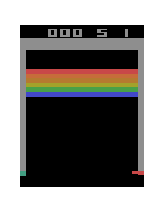
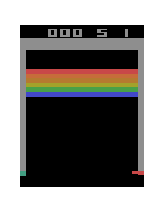
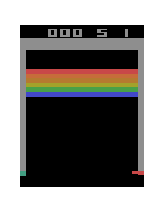
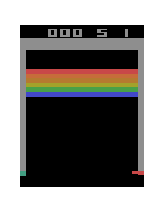
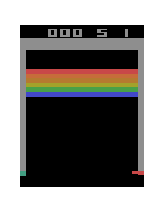
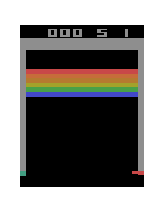
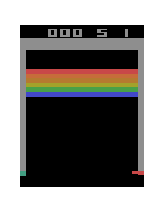
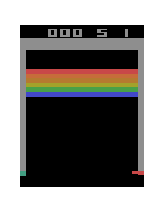
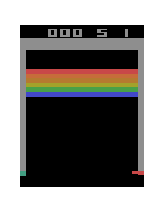
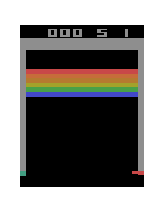
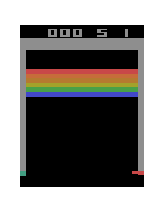
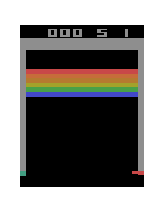
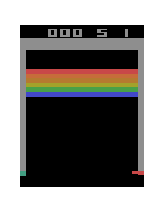
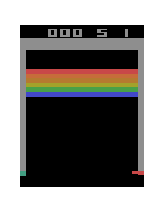
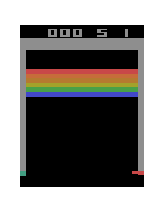
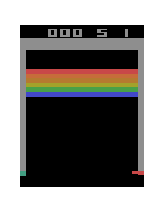
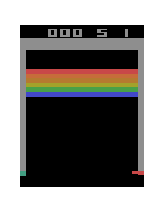
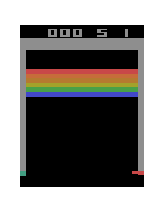
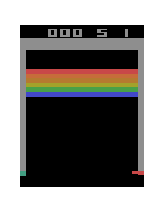
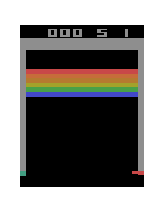
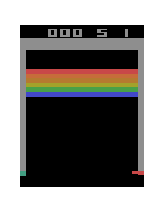
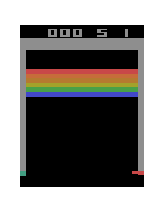
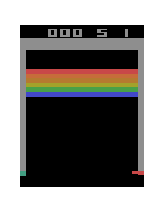
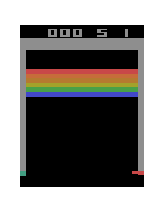
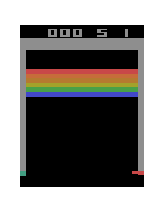
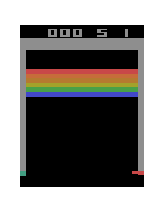
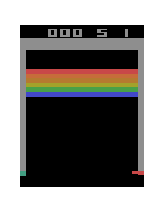
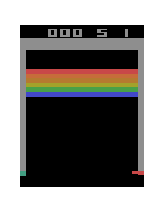
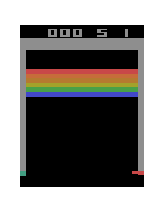
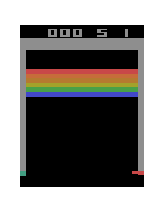
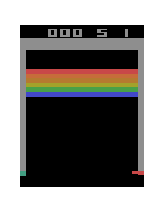
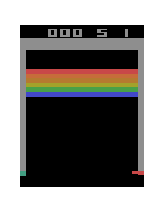
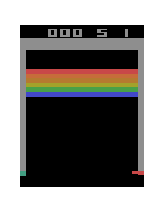
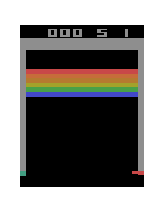
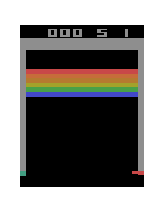
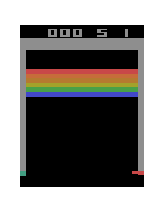
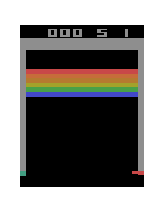
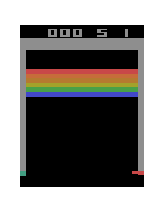
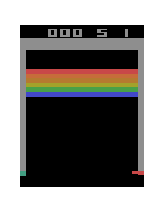
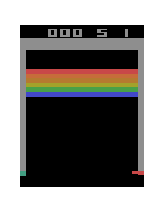
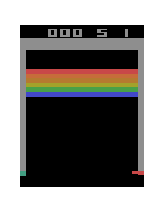
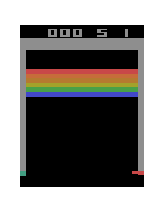
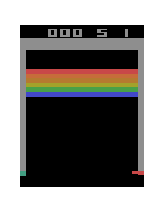
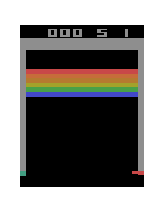
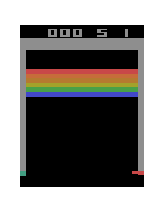
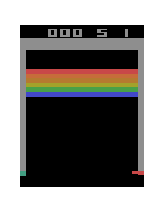
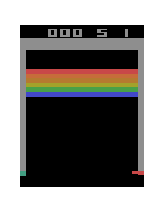
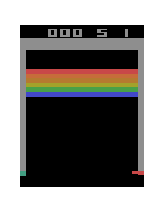
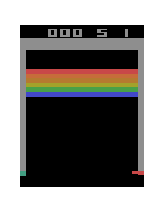
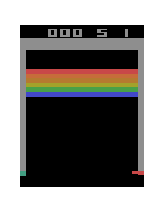
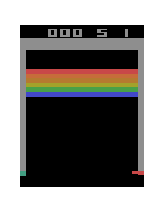
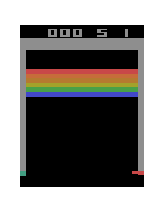
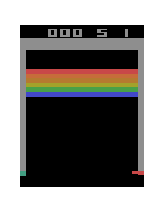
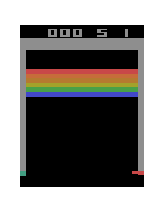
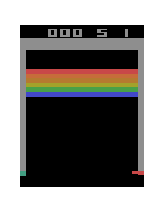
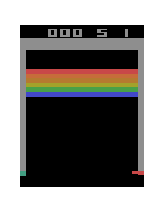
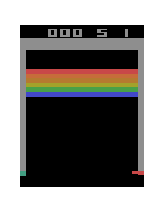
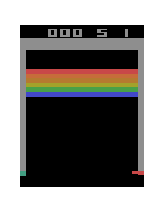
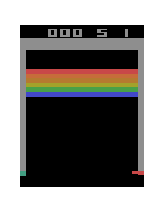
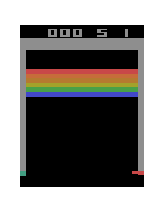
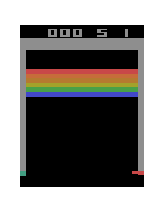
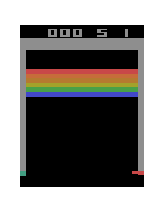
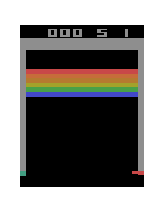
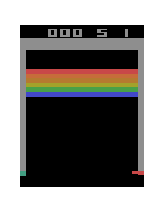
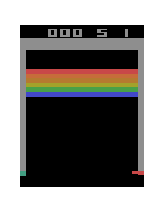
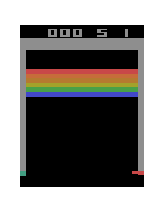
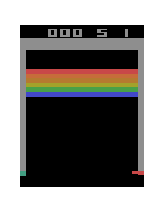
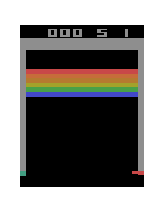
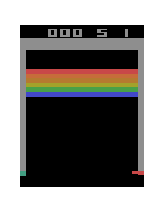
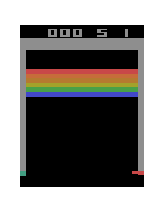
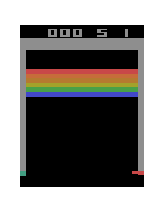
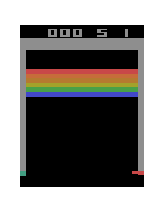
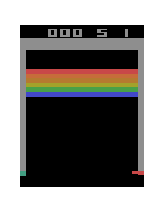
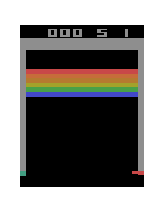
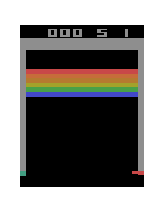
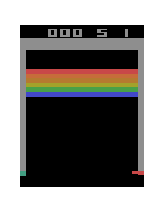
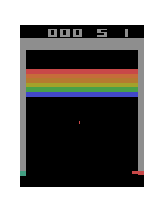
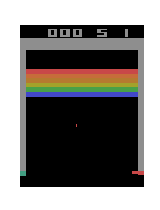
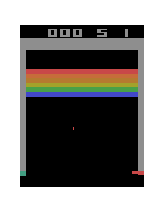
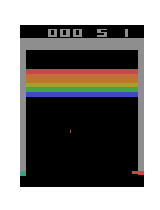
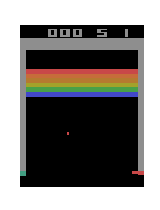
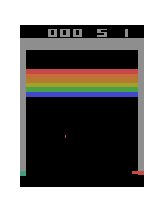
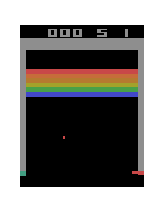
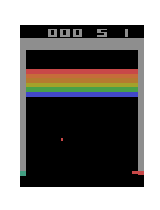
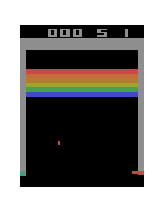
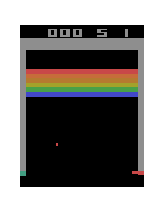
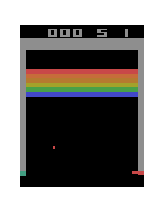
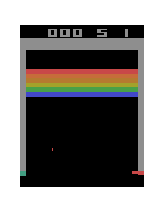
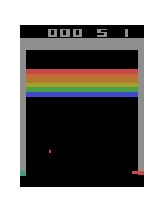
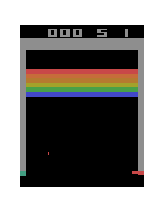
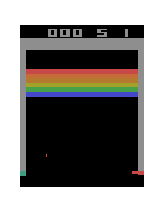
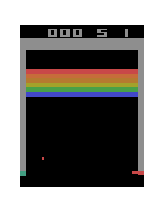
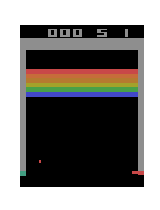
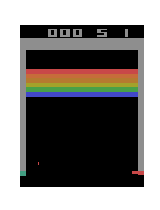
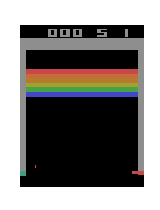
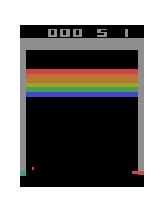
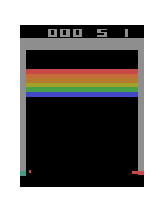
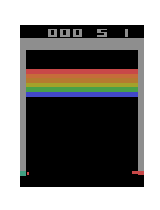
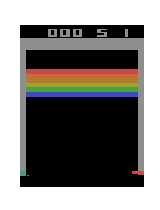
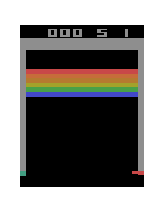
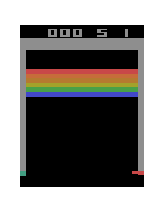
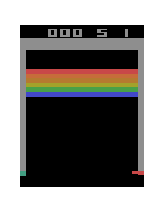
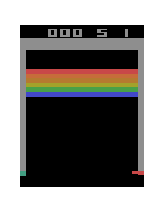
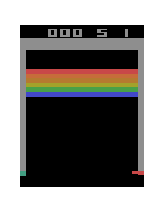
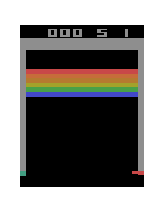
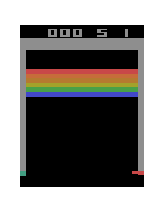
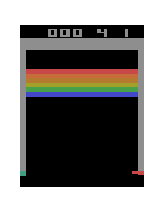
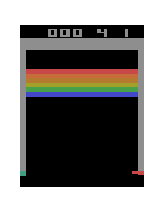
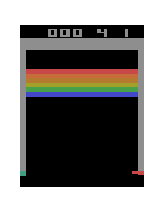
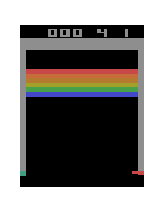
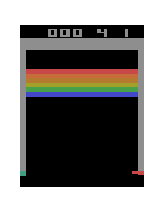
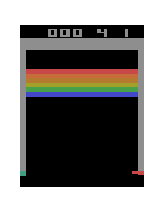
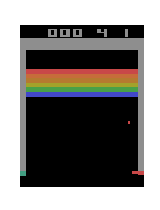
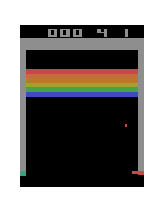
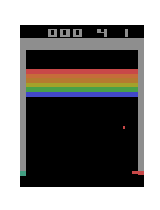
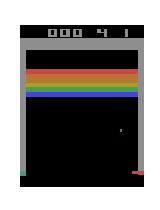
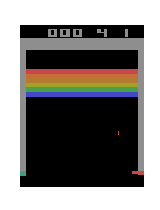
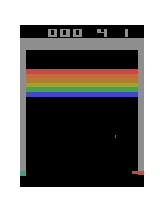
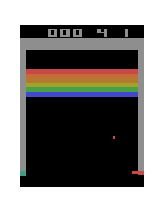
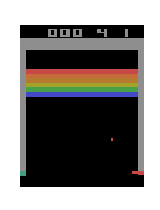
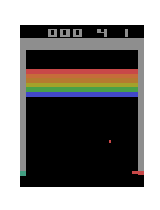
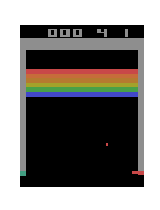
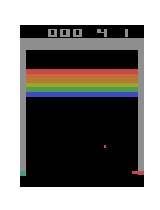
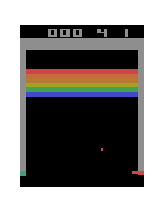
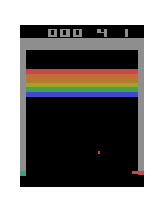
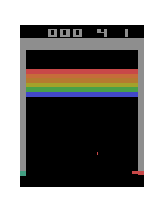
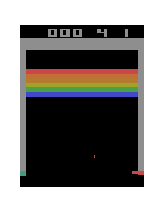
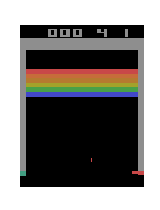
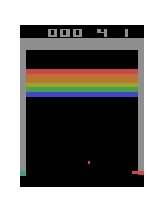
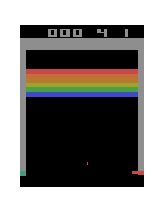
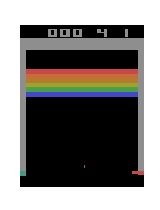
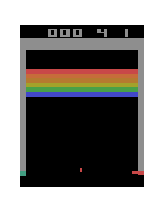
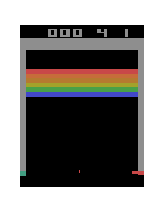
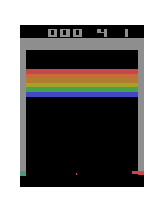
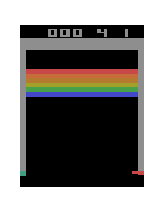
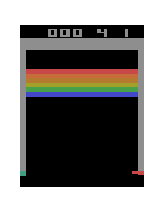
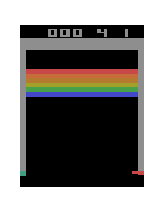
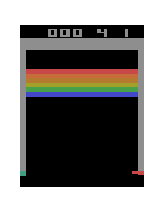
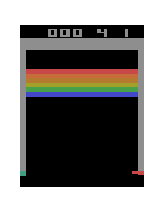
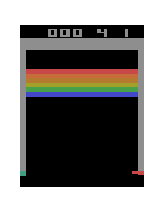
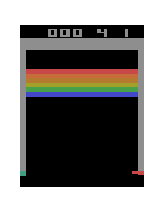
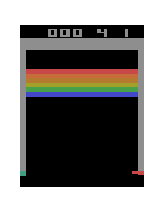
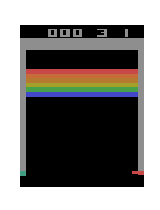
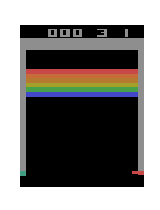
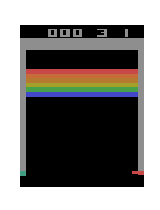
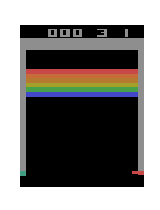
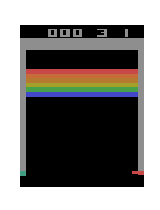
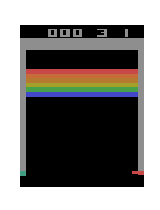
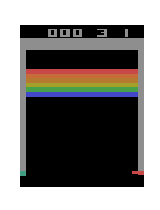
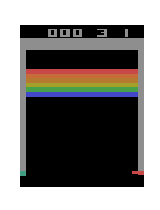
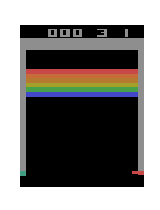
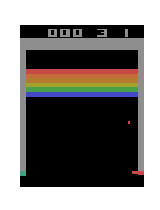
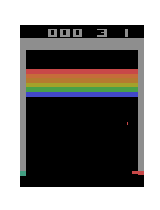
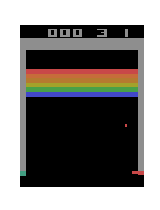
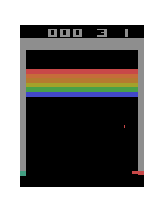

In [30]:
whoopframes = []
for epoch_i in range(1000):
    if random.random() <= 0.1:
        newaction = env.action_space.sample() 
    else:
        newimage = frames_to_nd_image(lastframes)
        actions = sess.run(output, feed_dict={inputimage:np.array([newimage], dtype=np.float32)})
        actions = actions[0]
        newaction = np.argmax(np.array(actions))

        
    newobservation, rewardhere, done, info = env.step(newaction)
    frame = env.render(mode = 'rgb_array')
    whoopframes.append(frame)
    
    observation_gray = rgb2gray(np.array(frame))
    lastframes.append(observation_gray)
    lastframes = lastframes[1:]

    newerimage = frames_to_nd_image(lastframes)
    estimatedfuturereward = max(max(sess.run(output, feed_dict={inputimage:np.array([newerimage])})))
    
    wanttoadd = (newimage, newaction, rewardhere+estimatedfuturereward)
#    state_rewards

    state
    if done:
        observation = env.reset()

display_frames_as_gif(whoopframes)        

In [ ]:
print(wanttoadd[0].shape)
print(wanttoadd[1])
print(wanttoadd[2])
print(state_rewards[0][0].shape)
print(state_rewards[0][1])
print(state_rewards[0][2])

In [ ]:
% matplotlib inline
plt.ioff()
plt.imshow(lastframes[3])
plt.show()
print(lastframes[2].shape)

frame = env.render(mode = 'rgb_array')
im.set_data(frame)

observation_gray = rgb2gray(np.array(frame))
print(observation_gray.shape)
history[0][0].shape

In [ ]:

print(inputimage)
print(np.array([newimage]).shape)
print(np.array([newimage],dtype=np.float32).dtype,)
print(output)
actions = sess.run(output, feed_dict={inputimage:np.array([newimage], dtype=np.float32)})
print(actions)

In [ ]:
print(lastframes[0].shape)
print(lastframes[0][50,2])
images, actions, values = get_random_hist(state_rewards, batch_size)
print(len(images))
print(images[0].shape)

In [ ]:

def show_episode(env, parameters):  
    observation = env.reset()
    firstframe = env.render(mode = 'rgb_array')
    frames = [firstframe]
    
    for _ in xrange(10500):
        action = env.action_space.sample() 

        observation, reward, done, info = env.step(action)
        frame = env.render(mode = 'rgb_array')
        frames.append(frame)
        if done:
            break
    return frames

frames = show_episode(env, bestparams)
display_frames_as_gif(frames)

### Conclusion
Congratulations! You made your first autonomous pole-balancer in the OpenAI gym environment. Now that this works it is time to either improve your algorithm, or start playing around with different environments. 

### Acknowledgments 
This blogpost is the first part of my TRADR summerschool workshop on using human input in reinforcement learning algorithms. More information can be found [on their homepage](https://sites.google.com/view/tradr/home)
